<a href="https://colab.research.google.com/github/loriszabo/protein_design/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [10]:
pip install biopython

In [11]:
# Modified ColabFold input cell: load multiple FASTA sequences -> write a multi-row CSV

from google.colab import files
import os
import re
import csv
import hashlib
from Bio import SeqIO
from sys import version_info

python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(prefix: str, s: str) -> str:
    return f"{prefix}_{hashlib.sha1(s.encode('utf-8')).hexdigest()[:5]}"


# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# ---- Upload a FASTA with multiple sequences ----
uploaded = files.upload()  # pops up file picker
fasta_file = list(uploaded.keys())[0]
print("Using FASTA:", fasta_file)

# ---- Job/folder name (one run folder containing many sequences) ----
jobname = "test"  # change if you want
basejobname = re.sub(r"\W+", "", "".join(jobname.split()))  # raw string regex

# ---- Parse FASTA and collect (id, seq) ----
records = list(SeqIO.parse(fasta_file, "fasta"))
if not records:
    raise ValueError(f"No FASTA records found in {fasta_file}")

queries = []
seen_ids = set()

for i, rec in enumerate(records, start=1):
    seq = str(rec.seq).strip().replace(" ", "").replace("\n", "").replace("\r", "")
    if not seq:
        continue

    # safe id for filenames/logs
    rid = re.sub(r"\W+", "", rec.id) or f"seq{i}"  # raw string regex
    rid = add_hash(rid, seq)

    # ensure uniqueness
    if rid in seen_ids:
        rid = f"{rid}_{i}"
    seen_ids.add(rid)

    queries.append((rid, seq))

if not queries:
    raise ValueError("All sequences were empty after cleaning.")

# Hash the whole input to avoid folder collisions across different FASTA uploads
all_seqs_concat = "|".join([s for _, s in queries])
jobname = add_hash(basejobname, all_seqs_concat)

# Ensure unique output folder name
def folder_available(path: str) -> bool:
    return not os.path.exists(path)

if not folder_available(jobname):
    n = 0
    while not folder_available(f"{jobname}_{n}"):
        n += 1
    jobname = f"{jobname}_{n}"

os.makedirs(jobname, exist_ok=True)

# Write ColabFold CSV: id,sequence (multiple rows)
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["id", "sequence"])
    for rid, seq in queries:
        w.writerow([rid, seq])

print("jobname:", jobname)
print("num sequences:", len(queries))
print("first id/len:", queries[0][0], len(queries[0][1].replace(":", "")))
print("wrote:", queries_path)

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

Saving generated_sequences_from_generated_proteins_2.fasta to generated_sequences_from_generated_proteins_2.fasta
Using FASTA: generated_sequences_from_generated_proteins_2.fasta
jobname: test_983d6
num sequences: 10
first id/len: Sample_0_0_89f2b 244
wrote: test_983d6/test_983d6.csv


In [12]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # hack to fix TF crash
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 2.61 ms, sys: 656 µs, total: 3.26 ms
Wall time: 42 s


In [13]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [14]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2026-01-01 15:46:55,036 Running on GPU
2026-01-01 15:46:55,369 Found 5 citations for tools or databases
2026-01-01 15:46:55,370 Query 1/10: Sample_1_0_8f04c (length 242)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


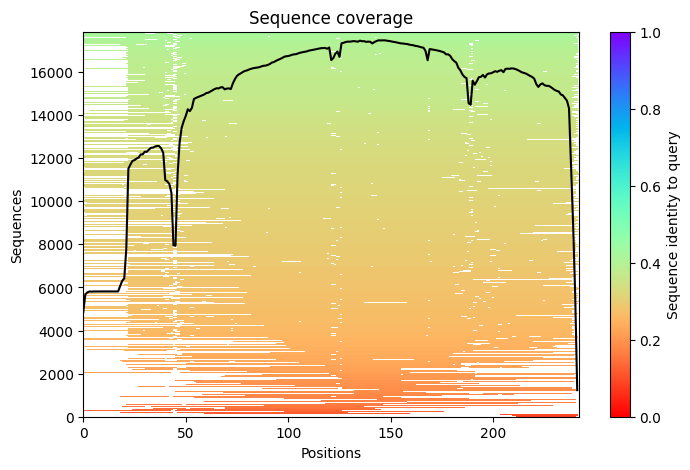

2026-01-01 15:47:19,447 Padding length to 252
2026-01-01 15:48:05,545 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=88.2 pTM=0.864
2026-01-01 15:48:41,377 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=88.9 pTM=0.867 tol=0.929
2026-01-01 15:49:00,790 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=88.9 pTM=0.869 tol=0.393
2026-01-01 15:49:20,443 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=89 pTM=0.87 tol=0.461
2026-01-01 15:49:20,443 alphafold2_ptm_model_1_seed_000 took 121.0s (3 recycles)


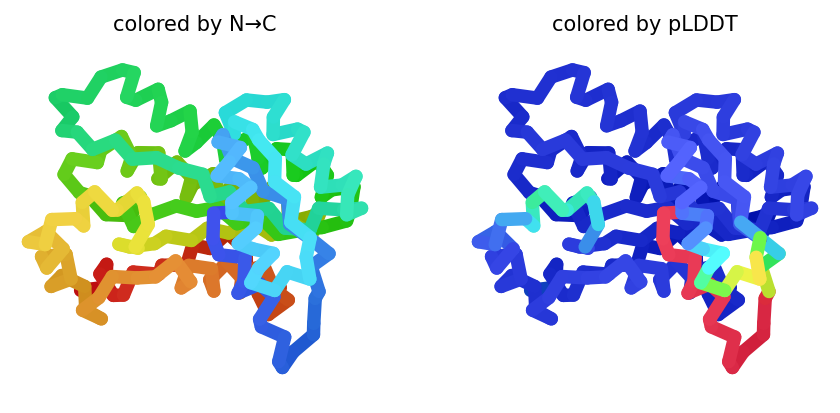

2026-01-01 15:49:40,239 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=88.5 pTM=0.873
2026-01-01 15:49:59,674 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=89 pTM=0.877 tol=0.701
2026-01-01 15:50:19,062 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=89.1 pTM=0.878 tol=0.171
2026-01-01 15:50:38,524 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=89.2 pTM=0.879 tol=0.171
2026-01-01 15:50:38,524 alphafold2_ptm_model_2_seed_000 took 77.9s (3 recycles)


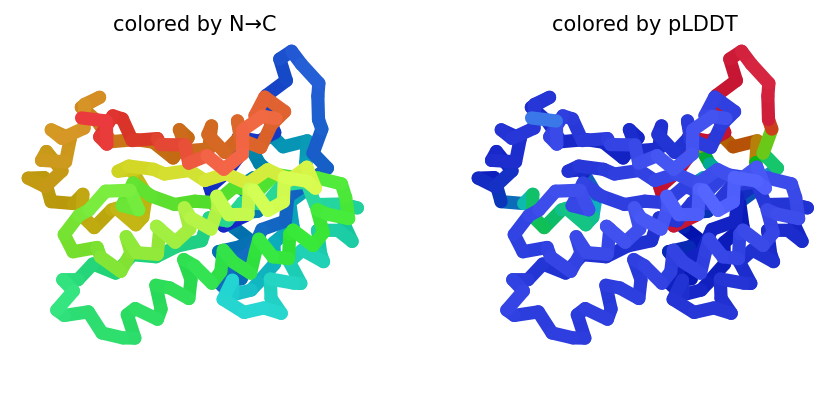

2026-01-01 15:50:58,213 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=88.1 pTM=0.871
2026-01-01 15:51:17,672 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=87.4 pTM=0.865 tol=0.547
2026-01-01 15:51:37,162 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=87.4 pTM=0.863 tol=0.26
2026-01-01 15:51:56,590 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=87.6 pTM=0.863 tol=0.122
2026-01-01 15:51:56,591 alphafold2_ptm_model_3_seed_000 took 77.9s (3 recycles)


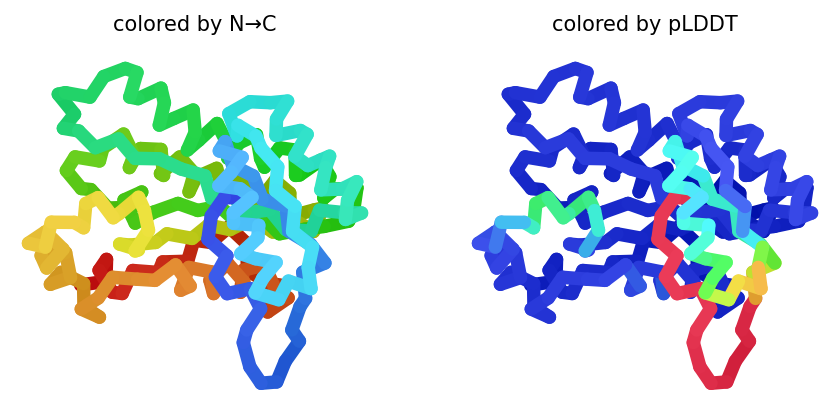

2026-01-01 15:52:16,266 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=89.4 pTM=0.874
2026-01-01 15:52:35,733 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=89.4 pTM=0.876 tol=0.47
2026-01-01 15:52:55,199 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=89.4 pTM=0.875 tol=0.168
2026-01-01 15:53:14,738 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=89.6 pTM=0.877 tol=0.244
2026-01-01 15:53:14,740 alphafold2_ptm_model_4_seed_000 took 78.0s (3 recycles)


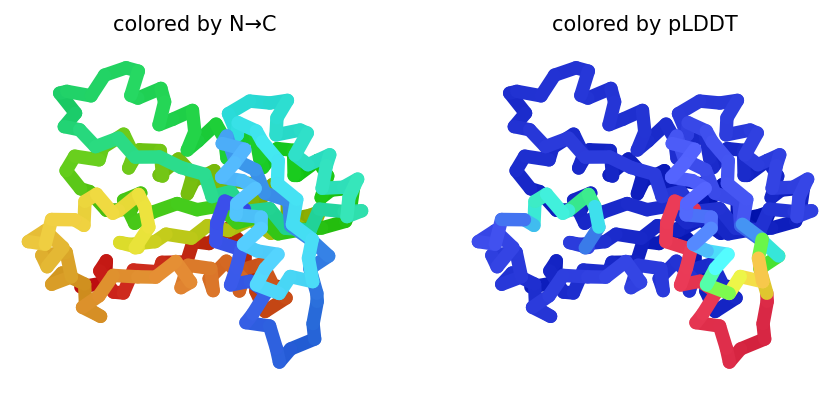

2026-01-01 15:53:34,542 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=86.8 pTM=0.868
2026-01-01 15:53:53,991 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=87.3 pTM=0.87 tol=0.774
2026-01-01 15:54:13,430 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=87.5 pTM=0.868 tol=0.152
2026-01-01 15:54:32,876 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=87.2 pTM=0.866 tol=0.276
2026-01-01 15:54:32,876 alphafold2_ptm_model_5_seed_000 took 77.8s (3 recycles)


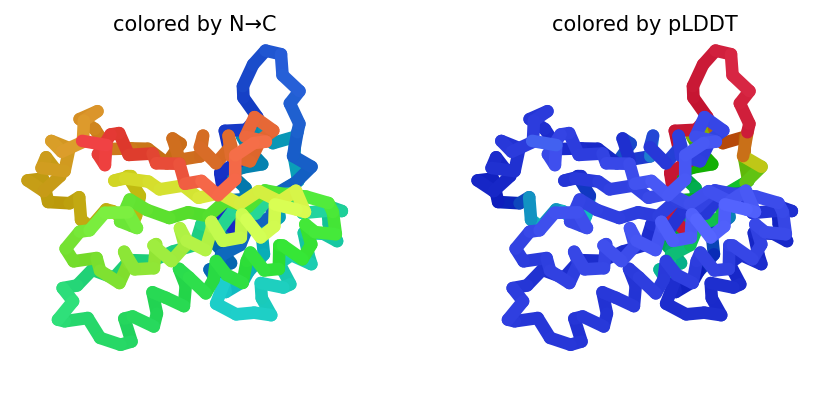

2026-01-01 15:54:33,059 reranking models by 'plddt' metric
2026-01-01 15:54:33,059 rank_001_alphafold2_ptm_model_4_seed_000 pLDDT=89.6 pTM=0.877
2026-01-01 15:54:33,060 rank_002_alphafold2_ptm_model_2_seed_000 pLDDT=89.2 pTM=0.879
2026-01-01 15:54:33,060 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=89 pTM=0.87
2026-01-01 15:54:33,060 rank_004_alphafold2_ptm_model_3_seed_000 pLDDT=87.6 pTM=0.863
2026-01-01 15:54:33,060 rank_005_alphafold2_ptm_model_5_seed_000 pLDDT=87.2 pTM=0.866
2026-01-01 15:54:34,326 Query 2/10: Sample_1_1_d72da (length 242)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


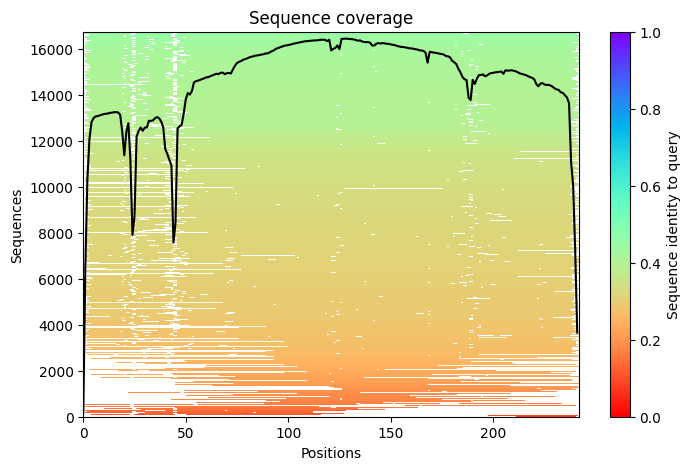

2026-01-01 15:54:46,289 Padding length to 252
2026-01-01 15:55:05,746 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=89.7 pTM=0.892
2026-01-01 15:55:25,496 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=90.8 pTM=0.897 tol=0.328
2026-01-01 15:55:44,990 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=89.8 pTM=0.891 tol=0.137
2026-01-01 15:56:04,409 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=90 pTM=0.894 tol=0.0867
2026-01-01 15:56:04,410 alphafold2_ptm_model_1_seed_000 took 78.1s (3 recycles)


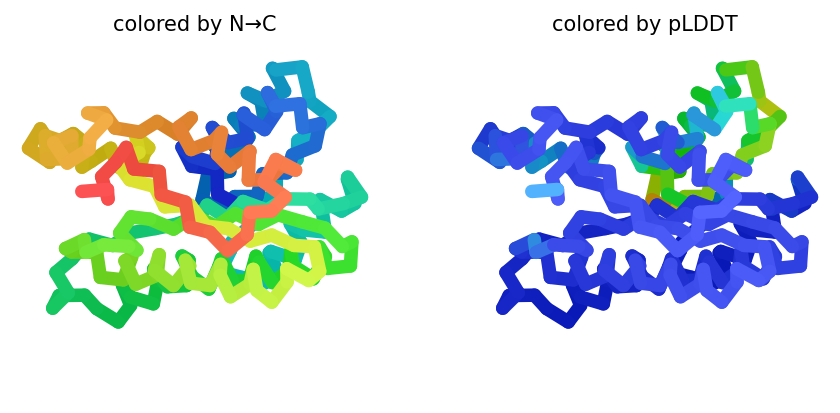

2026-01-01 15:56:24,106 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=90.8 pTM=0.902
2026-01-01 15:56:43,569 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=90.1 pTM=0.9 tol=0.223
2026-01-01 15:57:03,063 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=90.1 pTM=0.9 tol=0.146
2026-01-01 15:57:22,511 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=90.2 pTM=0.899 tol=0.0826
2026-01-01 15:57:22,511 alphafold2_ptm_model_2_seed_000 took 77.8s (3 recycles)


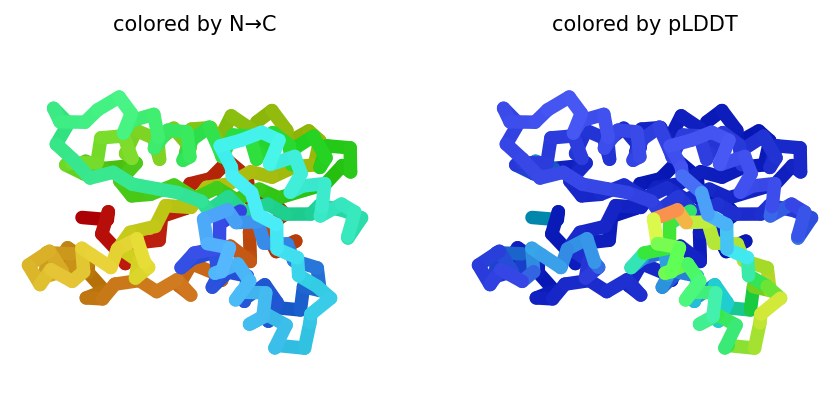

2026-01-01 15:57:42,185 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=92.1 pTM=0.91
2026-01-01 15:58:01,613 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=91.4 pTM=0.906 tol=0.356
2026-01-01 15:58:21,068 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=93.3 pTM=0.915 tol=0.61
2026-01-01 15:58:40,566 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=93.8 pTM=0.916 tol=0.0695
2026-01-01 15:58:40,567 alphafold2_ptm_model_3_seed_000 took 77.8s (3 recycles)


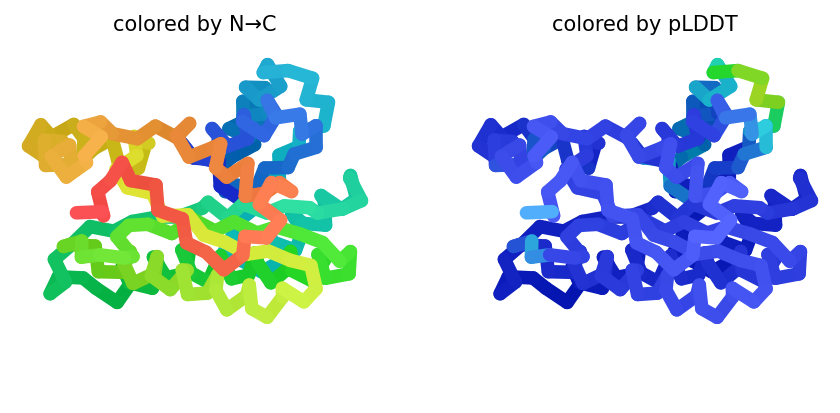

2026-01-01 15:59:00,363 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=91.2 pTM=0.904
2026-01-01 15:59:19,813 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=90.7 pTM=0.901 tol=0.225
2026-01-01 15:59:39,251 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=90.8 pTM=0.901 tol=0.17
2026-01-01 15:59:58,695 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=90.9 pTM=0.901 tol=0.198
2026-01-01 15:59:58,696 alphafold2_ptm_model_4_seed_000 took 77.8s (3 recycles)


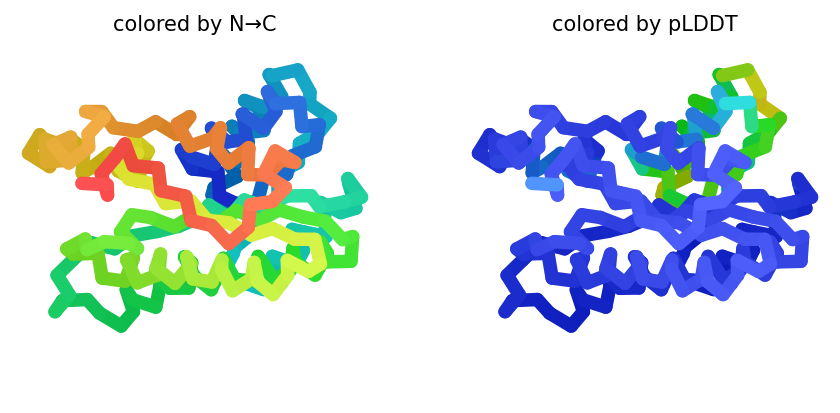

2026-01-01 16:00:18,416 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=91.6 pTM=0.91
2026-01-01 16:00:37,862 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=93 pTM=0.917 tol=0.504
2026-01-01 16:00:57,310 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=94.1 pTM=0.922 tol=0.32
2026-01-01 16:01:16,760 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=94.1 pTM=0.921 tol=0.25
2026-01-01 16:01:16,761 alphafold2_ptm_model_5_seed_000 took 77.9s (3 recycles)


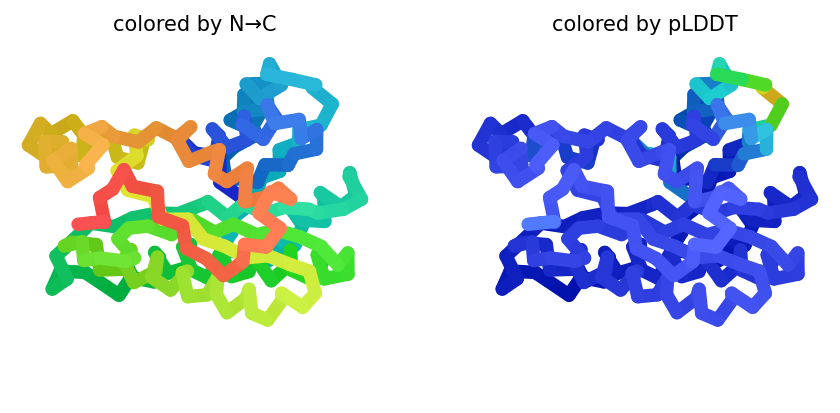

2026-01-01 16:01:16,954 reranking models by 'plddt' metric
2026-01-01 16:01:16,954 rank_001_alphafold2_ptm_model_5_seed_000 pLDDT=94.1 pTM=0.921
2026-01-01 16:01:16,954 rank_002_alphafold2_ptm_model_3_seed_000 pLDDT=93.8 pTM=0.916
2026-01-01 16:01:16,954 rank_003_alphafold2_ptm_model_4_seed_000 pLDDT=90.9 pTM=0.901
2026-01-01 16:01:16,955 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=90.2 pTM=0.899
2026-01-01 16:01:16,955 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=90 pTM=0.894
2026-01-01 16:01:18,389 Query 3/10: Sample_0_0_89f2b (length 244)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


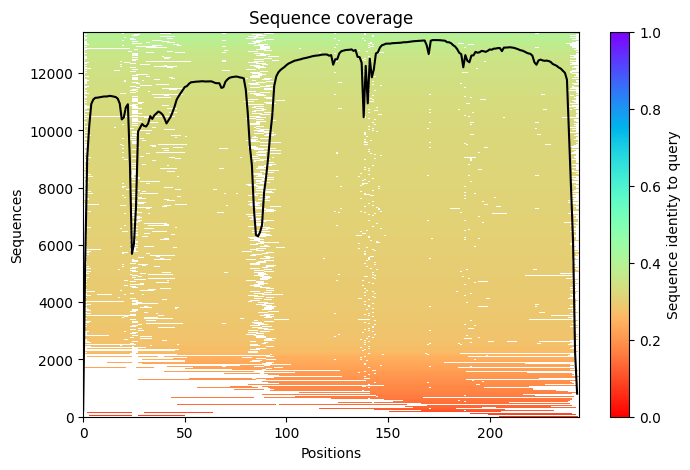

2026-01-01 16:01:29,380 Padding length to 252
2026-01-01 16:01:48,825 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=87.2 pTM=0.872
2026-01-01 16:02:08,506 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=87.8 pTM=0.872 tol=0.529
2026-01-01 16:02:27,977 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=88.3 pTM=0.876 tol=0.301
2026-01-01 16:02:47,294 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=88.7 pTM=0.878 tol=0.102
2026-01-01 16:02:47,295 alphafold2_ptm_model_1_seed_000 took 77.9s (3 recycles)


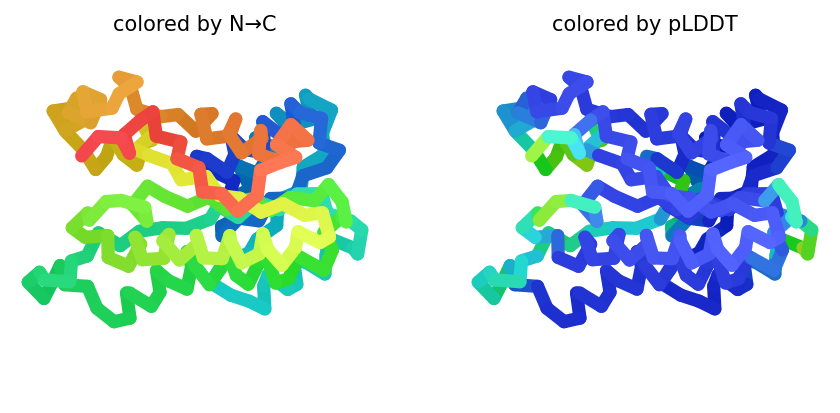

2026-01-01 16:03:06,927 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=87.4 pTM=0.88
2026-01-01 16:03:26,363 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=88.7 pTM=0.884 tol=0.517
2026-01-01 16:03:45,841 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=88.6 pTM=0.884 tol=0.288
2026-01-01 16:04:05,290 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=88.8 pTM=0.886 tol=0.0887
2026-01-01 16:04:05,290 alphafold2_ptm_model_2_seed_000 took 77.8s (3 recycles)


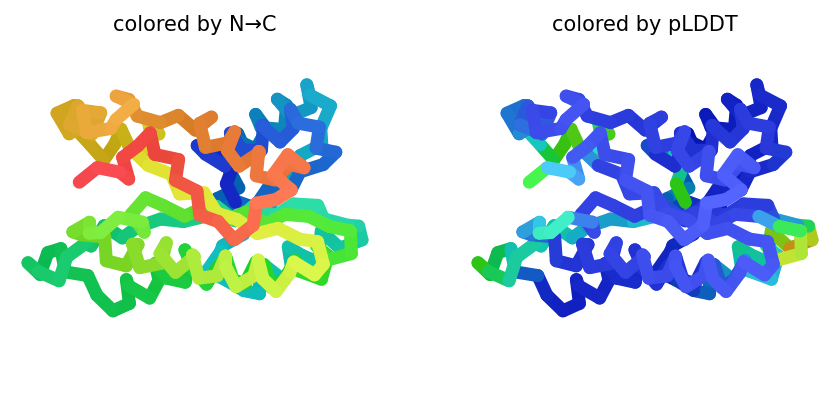

2026-01-01 16:04:24,898 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=87.7 pTM=0.877
2026-01-01 16:04:44,346 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=87.9 pTM=0.877 tol=0.472
2026-01-01 16:05:03,757 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=87.9 pTM=0.876 tol=0.237
2026-01-01 16:05:23,179 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=88.2 pTM=0.875 tol=0.332
2026-01-01 16:05:23,179 alphafold2_ptm_model_3_seed_000 took 77.7s (3 recycles)


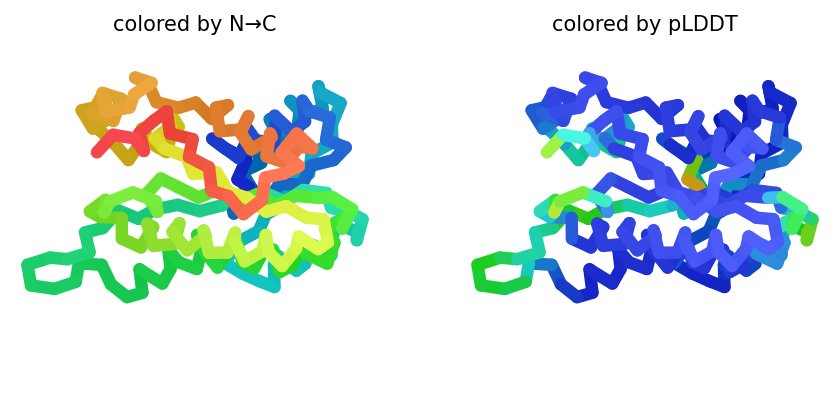

2026-01-01 16:05:42,821 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=87.1 pTM=0.879
2026-01-01 16:06:02,218 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=88.4 pTM=0.879 tol=0.687
2026-01-01 16:06:21,681 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=88.8 pTM=0.883 tol=0.311
2026-01-01 16:06:41,084 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=89.2 pTM=0.886 tol=0.174
2026-01-01 16:06:41,085 alphafold2_ptm_model_4_seed_000 took 77.7s (3 recycles)


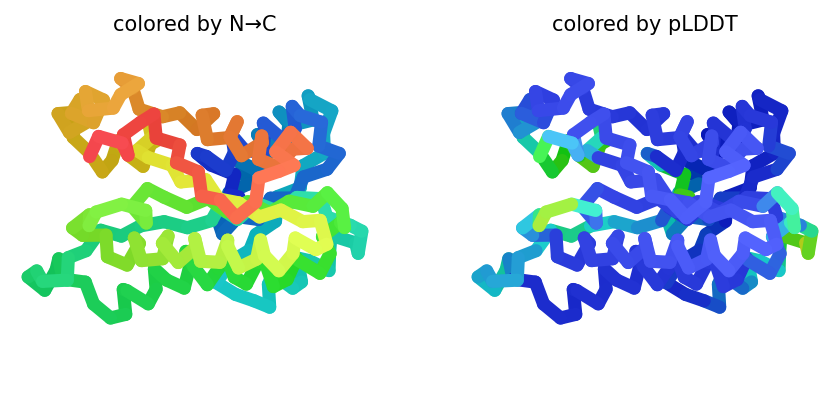

2026-01-01 16:07:00,725 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=87.7 pTM=0.884
2026-01-01 16:07:20,138 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=86.7 pTM=0.875 tol=0.733
2026-01-01 16:07:39,564 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=87.4 pTM=0.876 tol=0.409
2026-01-01 16:07:58,989 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=88 pTM=0.879 tol=0.329
2026-01-01 16:07:58,990 alphafold2_ptm_model_5_seed_000 took 77.7s (3 recycles)


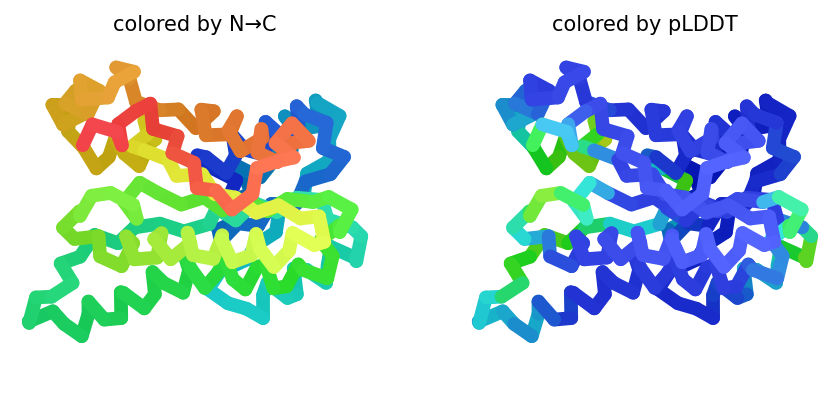

2026-01-01 16:07:59,202 reranking models by 'plddt' metric
2026-01-01 16:07:59,202 rank_001_alphafold2_ptm_model_4_seed_000 pLDDT=89.2 pTM=0.886
2026-01-01 16:07:59,203 rank_002_alphafold2_ptm_model_2_seed_000 pLDDT=88.8 pTM=0.886
2026-01-01 16:07:59,203 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=88.7 pTM=0.878
2026-01-01 16:07:59,203 rank_004_alphafold2_ptm_model_3_seed_000 pLDDT=88.2 pTM=0.875
2026-01-01 16:07:59,203 rank_005_alphafold2_ptm_model_5_seed_000 pLDDT=88 pTM=0.879
2026-01-01 16:08:00,466 Query 4/10: Sample_0_1_c5282 (length 244)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


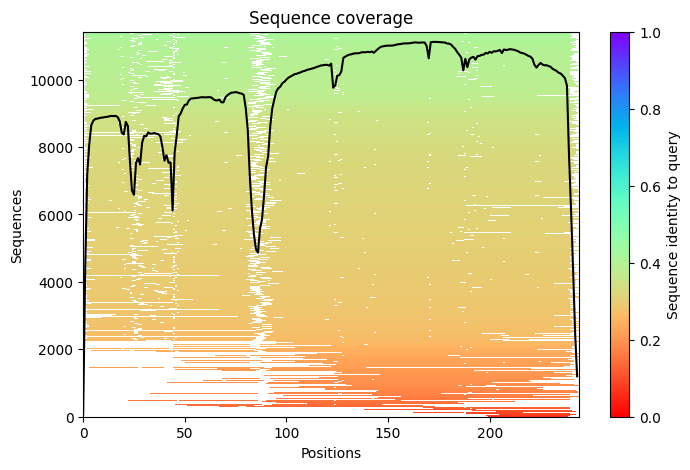

2026-01-01 16:08:09,411 Padding length to 252
2026-01-01 16:08:28,895 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=87.6 pTM=0.884
2026-01-01 16:08:48,567 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=87.3 pTM=0.882 tol=0.376
2026-01-01 16:09:08,023 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=88.2 pTM=0.885 tol=0.171
2026-01-01 16:09:27,370 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=88.8 pTM=0.889 tol=0.0771
2026-01-01 16:09:27,371 alphafold2_ptm_model_1_seed_000 took 78.0s (3 recycles)


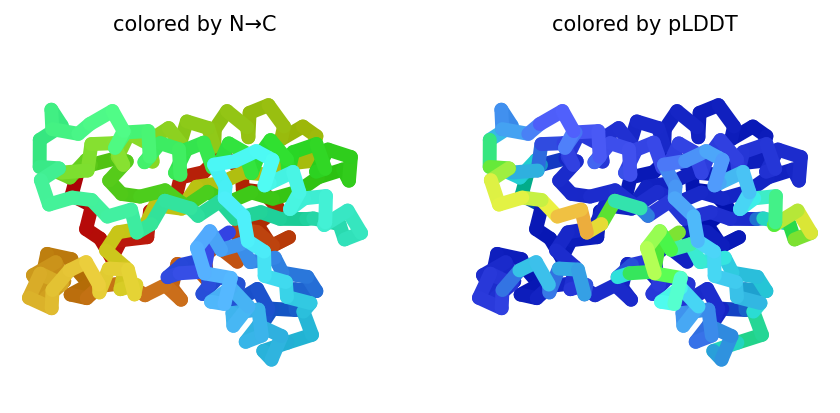

2026-01-01 16:09:47,079 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=87.7 pTM=0.892
2026-01-01 16:10:06,552 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=87.6 pTM=0.889 tol=0.382
2026-01-01 16:10:26,026 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=87.9 pTM=0.889 tol=0.198
2026-01-01 16:10:45,438 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=88.6 pTM=0.894 tol=0.297
2026-01-01 16:10:45,439 alphafold2_ptm_model_2_seed_000 took 77.9s (3 recycles)


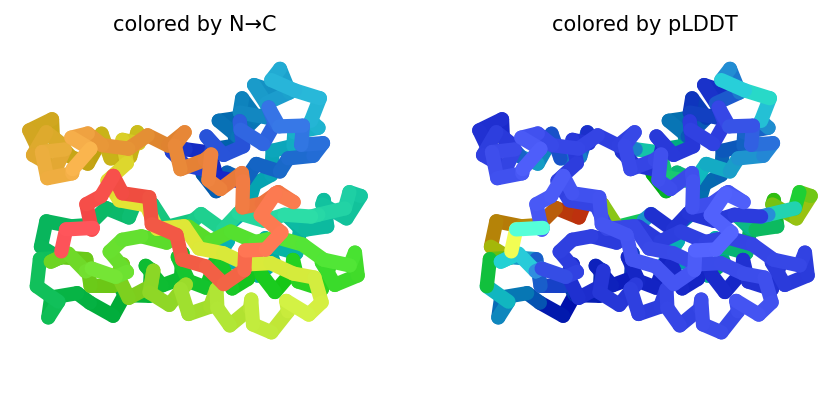

2026-01-01 16:11:05,068 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=88.4 pTM=0.892
2026-01-01 16:11:24,555 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=88.4 pTM=0.893 tol=0.292
2026-01-01 16:11:44,000 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=88.4 pTM=0.893 tol=0.11
2026-01-01 16:12:03,437 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=88.9 pTM=0.895 tol=0.0755
2026-01-01 16:12:03,437 alphafold2_ptm_model_3_seed_000 took 77.8s (3 recycles)


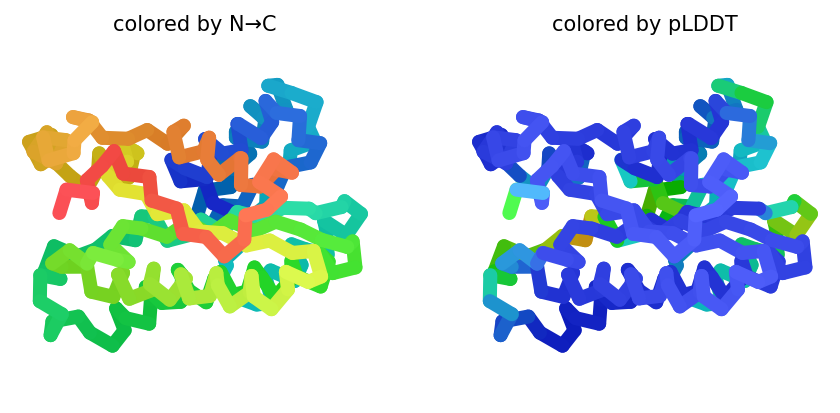

2026-01-01 16:12:23,142 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=88.4 pTM=0.895
2026-01-01 16:12:42,581 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=88.2 pTM=0.894 tol=0.288
2026-01-01 16:13:02,037 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=88.8 pTM=0.896 tol=0.153
2026-01-01 16:13:21,464 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=89.2 pTM=0.898 tol=0.102
2026-01-01 16:13:21,464 alphafold2_ptm_model_4_seed_000 took 77.8s (3 recycles)


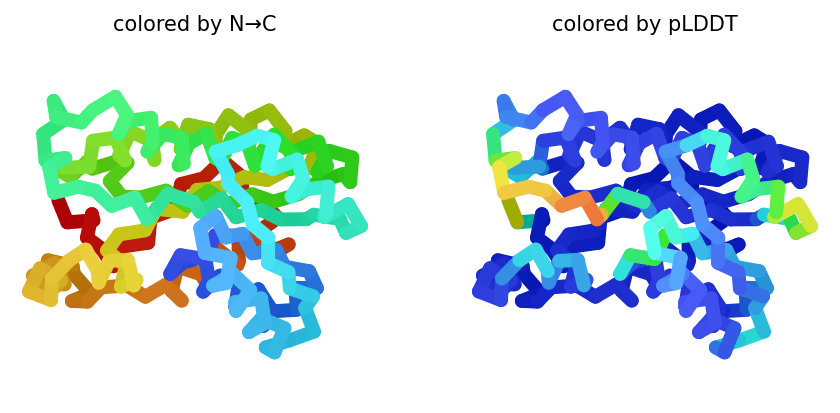

2026-01-01 16:13:41,126 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=87 pTM=0.888
2026-01-01 16:14:00,555 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=87.3 pTM=0.891 tol=0.413
2026-01-01 16:14:19,972 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=87.1 pTM=0.888 tol=0.35
2026-01-01 16:14:39,406 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=87.7 pTM=0.891 tol=0.106
2026-01-01 16:14:39,407 alphafold2_ptm_model_5_seed_000 took 77.7s (3 recycles)


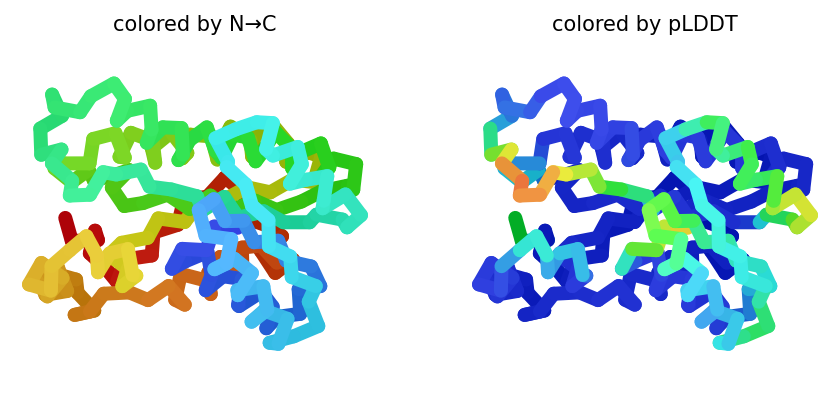

2026-01-01 16:14:39,631 reranking models by 'plddt' metric
2026-01-01 16:14:39,632 rank_001_alphafold2_ptm_model_4_seed_000 pLDDT=89.2 pTM=0.898
2026-01-01 16:14:39,632 rank_002_alphafold2_ptm_model_3_seed_000 pLDDT=88.9 pTM=0.895
2026-01-01 16:14:39,632 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=88.8 pTM=0.889
2026-01-01 16:14:39,632 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=88.6 pTM=0.894
2026-01-01 16:14:39,632 rank_005_alphafold2_ptm_model_5_seed_000 pLDDT=87.7 pTM=0.891
2026-01-01 16:14:40,914 Query 5/10: Sample_4_0_eb903 (length 315)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


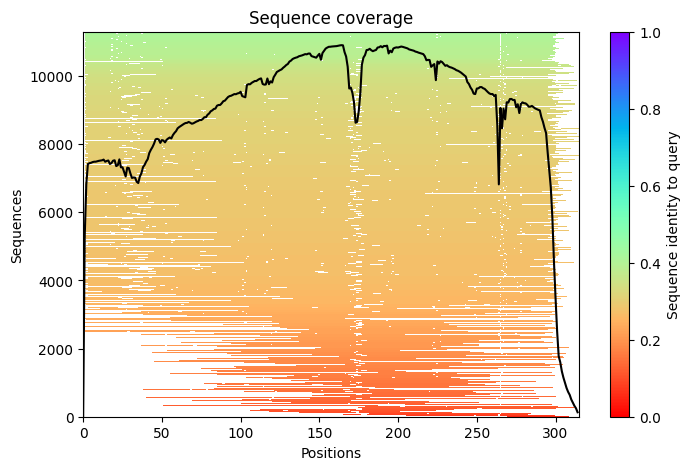

2026-01-01 16:14:53,872 Padding length to 325
2026-01-01 16:15:52,870 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=84.4 pTM=0.858
2026-01-01 16:16:41,552 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=85.6 pTM=0.869 tol=3.03
2026-01-01 16:17:11,118 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=85.8 pTM=0.868 tol=0.447
2026-01-01 16:17:40,343 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=86.3 pTM=0.868 tol=0.558
2026-01-01 16:17:40,343 alphafold2_ptm_model_1_seed_000 took 166.5s (3 recycles)


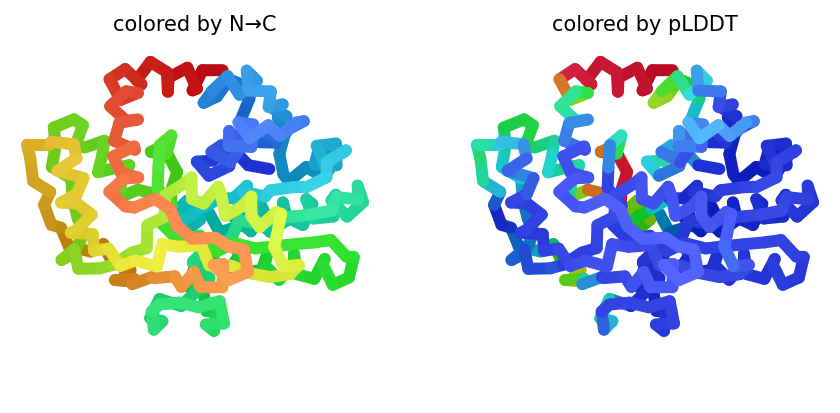

2026-01-01 16:18:10,047 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=85.4 pTM=0.873
2026-01-01 16:18:39,418 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=86.6 pTM=0.877 tol=2.84
2026-01-01 16:19:08,665 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=86.1 pTM=0.877 tol=0.826
2026-01-01 16:19:37,979 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=86.4 pTM=0.877 tol=0.301
2026-01-01 16:19:37,981 alphafold2_ptm_model_2_seed_000 took 117.2s (3 recycles)


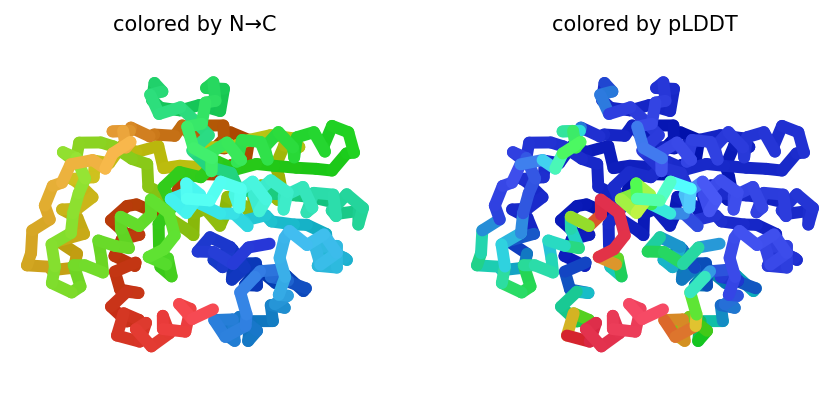

2026-01-01 16:20:07,719 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=85.4 pTM=0.868
2026-01-01 16:20:37,041 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=85 pTM=0.868 tol=2.81
2026-01-01 16:21:06,336 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=85.7 pTM=0.869 tol=0.258
2026-01-01 16:21:35,628 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=86 pTM=0.87 tol=0.246
2026-01-01 16:21:35,628 alphafold2_ptm_model_3_seed_000 took 117.4s (3 recycles)


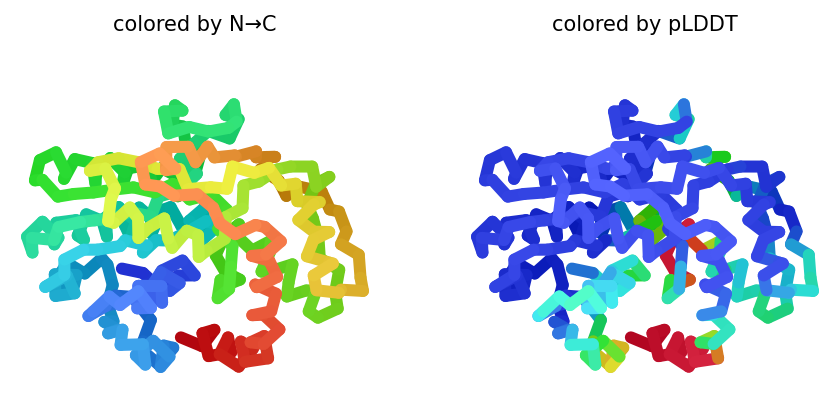

2026-01-01 16:22:05,198 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=84.2 pTM=0.863
2026-01-01 16:22:34,465 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=84.6 pTM=0.865 tol=1.62
2026-01-01 16:23:03,776 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=85.1 pTM=0.868 tol=0.466
2026-01-01 16:23:33,199 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=85.2 pTM=0.867 tol=0.381
2026-01-01 16:23:33,200 alphafold2_ptm_model_4_seed_000 took 117.3s (3 recycles)


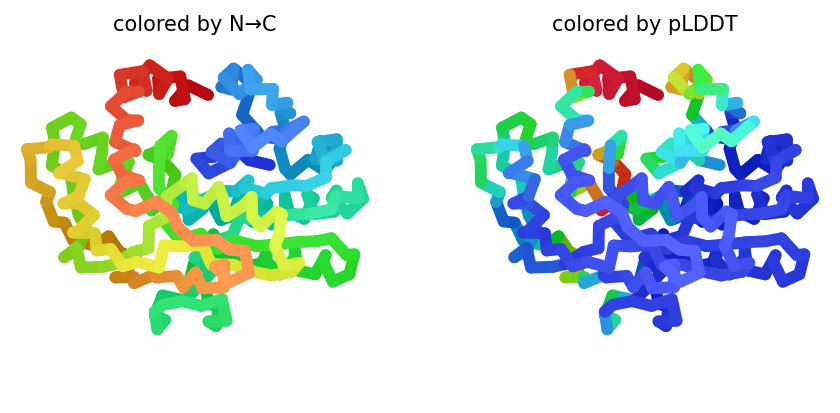

2026-01-01 16:24:02,934 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=84.8 pTM=0.875
2026-01-01 16:24:32,218 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=85.2 pTM=0.875 tol=0.91
2026-01-01 16:25:01,545 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=85.1 pTM=0.873 tol=0.465
2026-01-01 16:25:30,865 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=84.6 pTM=0.87 tol=0.293
2026-01-01 16:25:30,866 alphafold2_ptm_model_5_seed_000 took 117.3s (3 recycles)


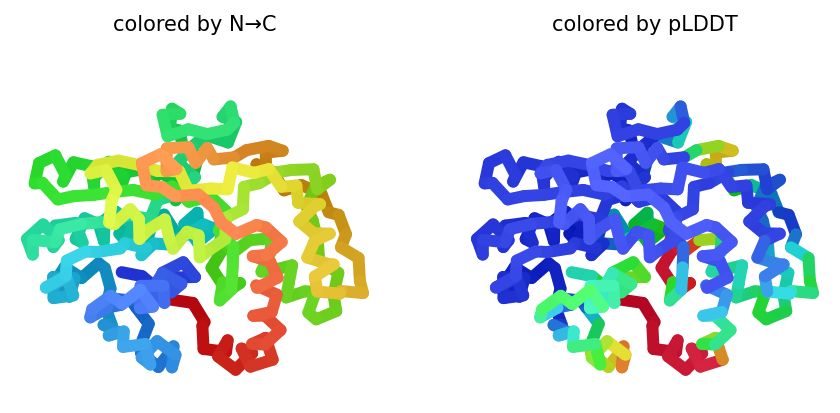

2026-01-01 16:25:31,142 reranking models by 'plddt' metric
2026-01-01 16:25:31,142 rank_001_alphafold2_ptm_model_2_seed_000 pLDDT=86.4 pTM=0.877
2026-01-01 16:25:31,143 rank_002_alphafold2_ptm_model_1_seed_000 pLDDT=86.3 pTM=0.868
2026-01-01 16:25:31,143 rank_003_alphafold2_ptm_model_3_seed_000 pLDDT=86 pTM=0.87
2026-01-01 16:25:31,143 rank_004_alphafold2_ptm_model_4_seed_000 pLDDT=85.2 pTM=0.867
2026-01-01 16:25:31,143 rank_005_alphafold2_ptm_model_5_seed_000 pLDDT=84.6 pTM=0.87
2026-01-01 16:25:32,489 Query 6/10: Sample_4_1_0c970 (length 315)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


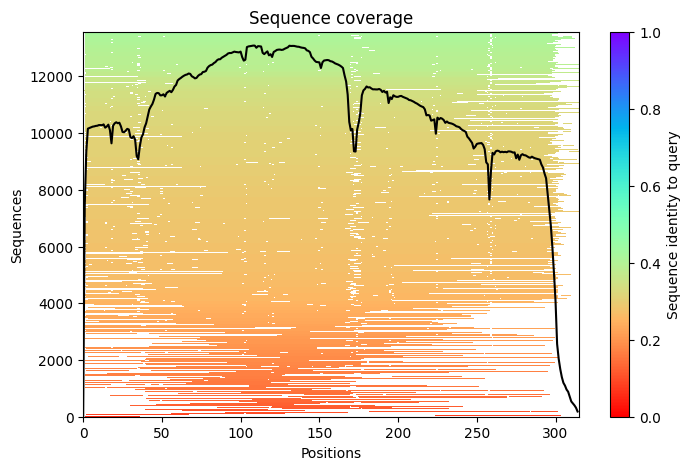

2026-01-01 16:25:45,348 Padding length to 325
2026-01-01 16:26:14,888 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=87.6 pTM=0.886
2026-01-01 16:26:44,411 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=87.6 pTM=0.888 tol=0.346
2026-01-01 16:27:13,670 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=87.5 pTM=0.883 tol=0.291
2026-01-01 16:27:43,017 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=87.5 pTM=0.884 tol=0.228
2026-01-01 16:27:43,018 alphafold2_ptm_model_1_seed_000 took 117.7s (3 recycles)


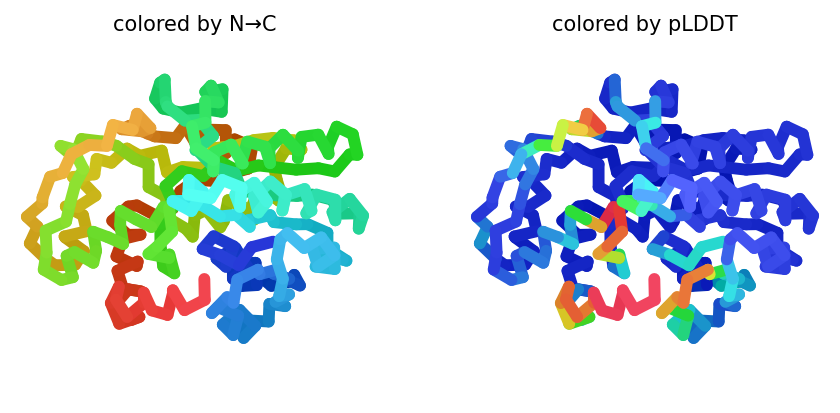

2026-01-01 16:28:12,740 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=87.2 pTM=0.885
2026-01-01 16:28:42,019 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=87.2 pTM=0.89 tol=0.378
2026-01-01 16:29:11,330 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=87.6 pTM=0.889 tol=0.208
2026-01-01 16:29:40,688 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=87.6 pTM=0.888 tol=0.205
2026-01-01 16:29:40,689 alphafold2_ptm_model_2_seed_000 took 117.3s (3 recycles)


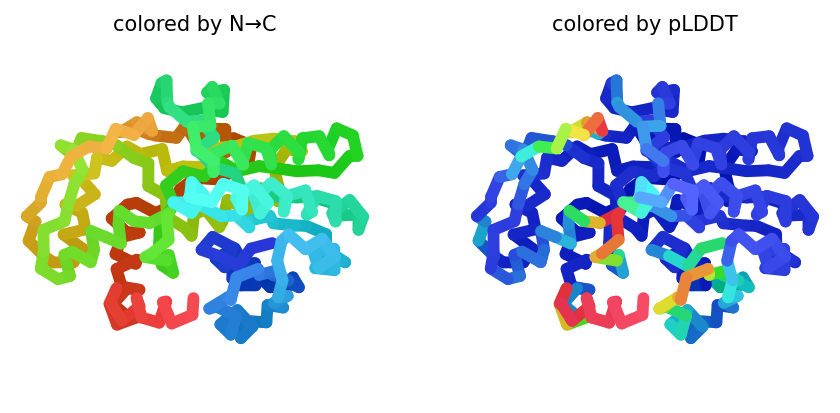

2026-01-01 16:30:10,294 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=87.5 pTM=0.878
2026-01-01 16:30:39,715 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=87.8 pTM=0.887 tol=0.406
2026-01-01 16:31:09,007 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=88.6 pTM=0.892 tol=0.29
2026-01-01 16:31:38,307 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=88.4 pTM=0.89 tol=0.169
2026-01-01 16:31:38,308 alphafold2_ptm_model_3_seed_000 took 117.3s (3 recycles)


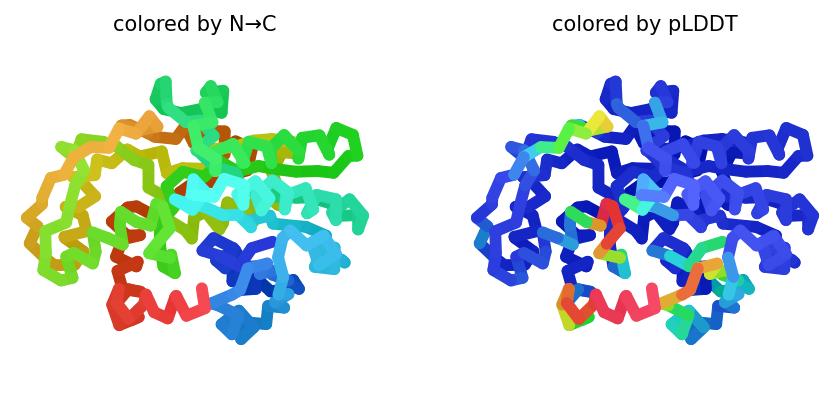

2026-01-01 16:32:07,915 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=87.8 pTM=0.888
2026-01-01 16:32:37,237 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=87.8 pTM=0.889 tol=0.384
2026-01-01 16:33:06,585 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=87.9 pTM=0.888 tol=0.404
2026-01-01 16:33:35,913 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=88.1 pTM=0.89 tol=0.106
2026-01-01 16:33:35,913 alphafold2_ptm_model_4_seed_000 took 117.3s (3 recycles)


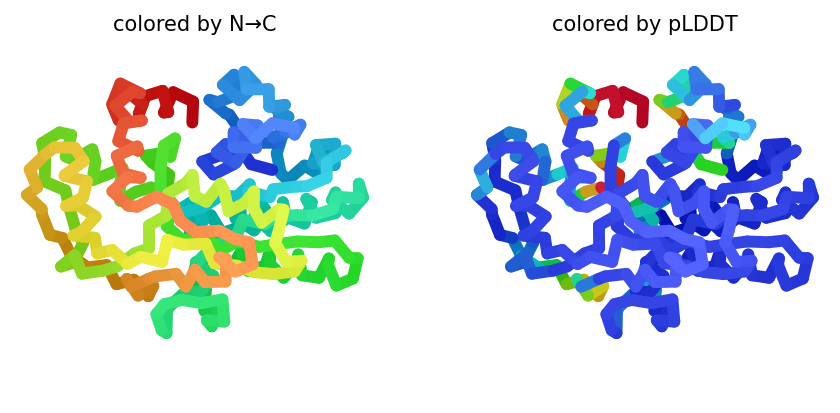

2026-01-01 16:34:05,657 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=87.4 pTM=0.889
2026-01-01 16:34:34,996 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=88 pTM=0.894 tol=0.474
2026-01-01 16:35:04,332 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=88.1 pTM=0.89 tol=0.2
2026-01-01 16:35:33,686 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=88.3 pTM=0.89 tol=0.113
2026-01-01 16:35:33,687 alphafold2_ptm_model_5_seed_000 took 117.5s (3 recycles)


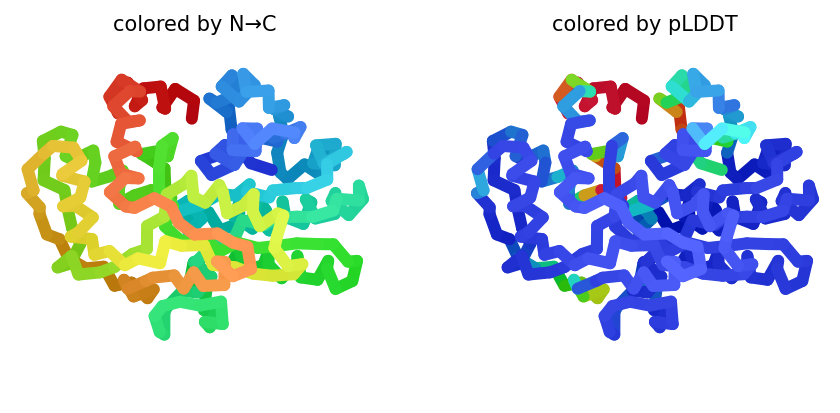

2026-01-01 16:35:33,987 reranking models by 'plddt' metric
2026-01-01 16:35:33,987 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=88.4 pTM=0.89
2026-01-01 16:35:33,988 rank_002_alphafold2_ptm_model_5_seed_000 pLDDT=88.3 pTM=0.89
2026-01-01 16:35:33,988 rank_003_alphafold2_ptm_model_4_seed_000 pLDDT=88.1 pTM=0.89
2026-01-01 16:35:33,988 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=87.6 pTM=0.888
2026-01-01 16:35:33,988 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=87.5 pTM=0.884
2026-01-01 16:35:35,738 Query 7/10: Sample_3_0_d4cd2 (length 326)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


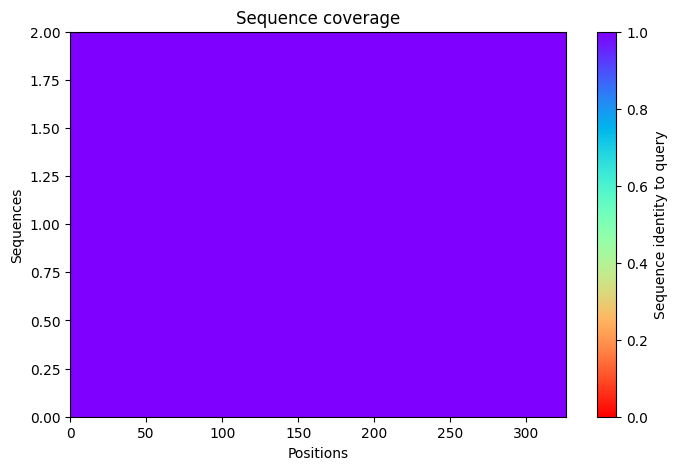

2026-01-01 16:35:38,409 Padding length to 336
2026-01-01 16:36:38,756 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=44.4 pTM=0.221
2026-01-01 16:37:24,739 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=42.5 pTM=0.238 tol=11.5
2026-01-01 16:37:53,437 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=43.2 pTM=0.261 tol=12.4
2026-01-01 16:38:21,847 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=44 pTM=0.281 tol=3.91
2026-01-01 16:38:21,847 alphafold2_ptm_model_1_seed_000 took 163.4s (3 recycles)


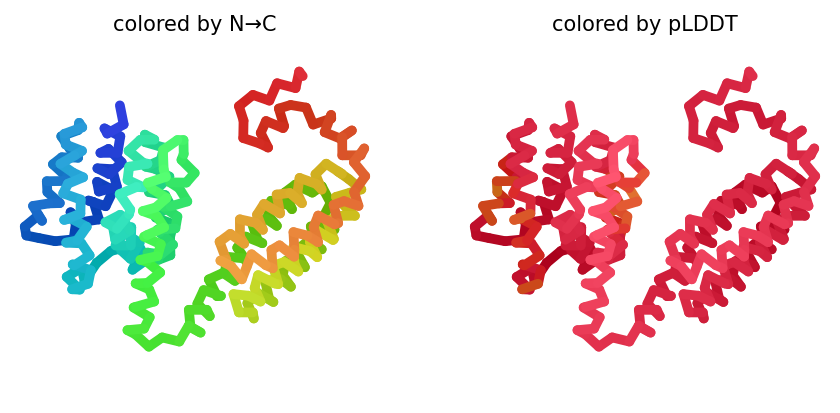

2026-01-01 16:38:50,697 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=43.3 pTM=0.244
2026-01-01 16:39:19,188 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=44 pTM=0.287 tol=7.73
2026-01-01 16:39:47,691 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=44.3 pTM=0.305 tol=2.64
2026-01-01 16:40:16,118 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=45 pTM=0.308 tol=1.25
2026-01-01 16:40:16,119 alphafold2_ptm_model_2_seed_000 took 113.9s (3 recycles)


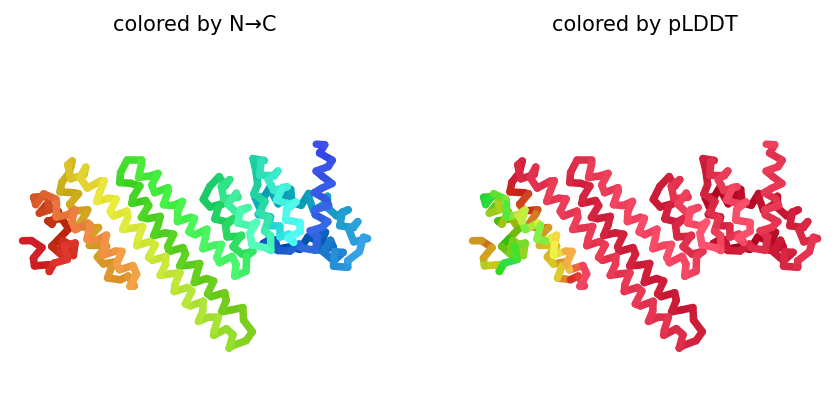

2026-01-01 16:40:44,851 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=37.8 pTM=0.212
2026-01-01 16:41:13,304 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=36.7 pTM=0.226 tol=9.77
2026-01-01 16:41:41,742 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=40 pTM=0.232 tol=5.04
2026-01-01 16:42:10,180 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=39.6 pTM=0.238 tol=1.47
2026-01-01 16:42:10,181 alphafold2_ptm_model_3_seed_000 took 113.8s (3 recycles)


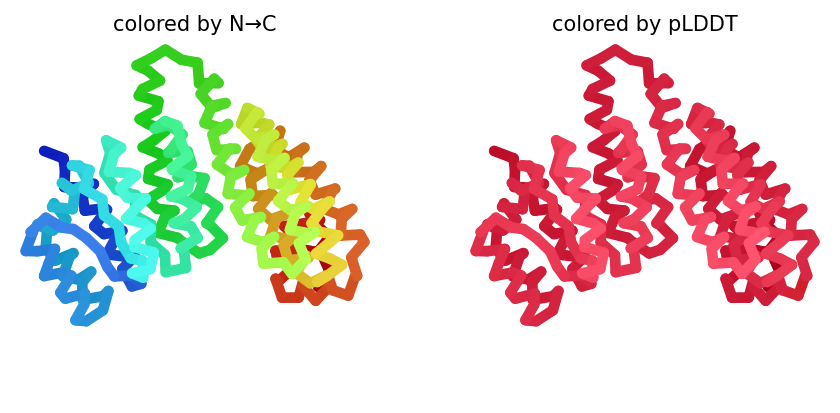

2026-01-01 16:42:38,921 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=42.2 pTM=0.208
2026-01-01 16:43:07,370 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=41.8 pTM=0.217 tol=9.05
2026-01-01 16:43:35,825 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=41.7 pTM=0.229 tol=3.6
2026-01-01 16:44:04,251 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=40 pTM=0.214 tol=5.37
2026-01-01 16:44:04,252 alphafold2_ptm_model_4_seed_000 took 113.8s (3 recycles)


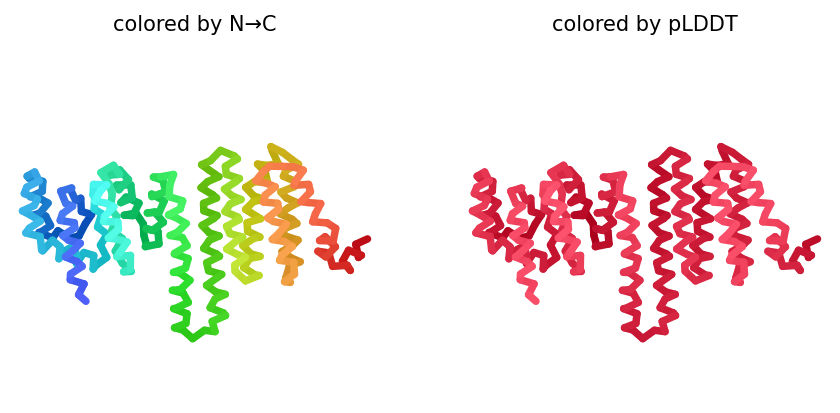

2026-01-01 16:44:32,988 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=39.6 pTM=0.259
2026-01-01 16:45:01,441 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=37.2 pTM=0.223 tol=7.09
2026-01-01 16:45:29,845 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=39.4 pTM=0.24 tol=5.79
2026-01-01 16:45:58,276 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=41 pTM=0.298 tol=3.17
2026-01-01 16:45:58,276 alphafold2_ptm_model_5_seed_000 took 113.7s (3 recycles)


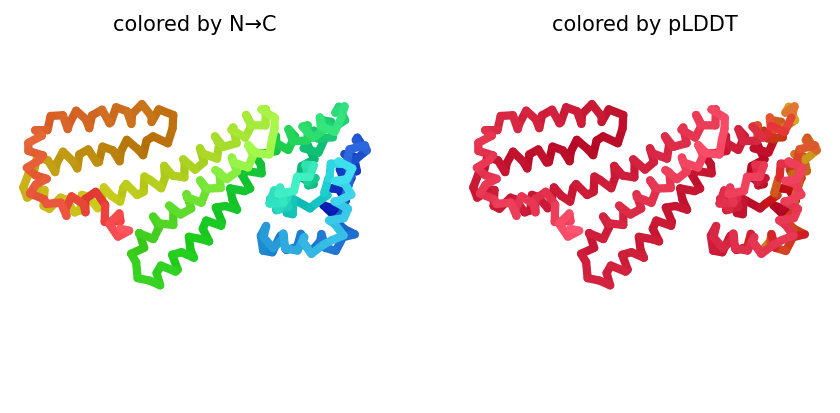

2026-01-01 16:45:58,568 reranking models by 'plddt' metric
2026-01-01 16:45:58,569 rank_001_alphafold2_ptm_model_2_seed_000 pLDDT=45 pTM=0.308
2026-01-01 16:45:58,569 rank_002_alphafold2_ptm_model_1_seed_000 pLDDT=44 pTM=0.281
2026-01-01 16:45:58,570 rank_003_alphafold2_ptm_model_5_seed_000 pLDDT=41 pTM=0.298
2026-01-01 16:45:58,570 rank_004_alphafold2_ptm_model_4_seed_000 pLDDT=40 pTM=0.214
2026-01-01 16:45:58,570 rank_005_alphafold2_ptm_model_3_seed_000 pLDDT=39.6 pTM=0.238
2026-01-01 16:45:59,960 Query 8/10: Sample_3_1_938cd (length 326)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


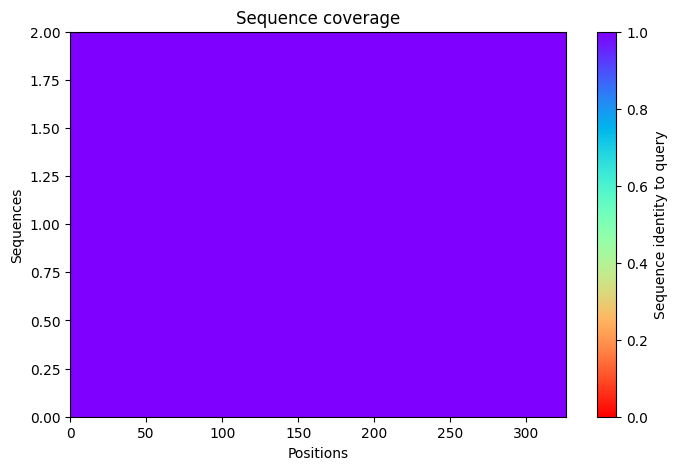

2026-01-01 16:46:02,752 Padding length to 336
2026-01-01 16:46:31,316 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=44.1 pTM=0.256
2026-01-01 16:46:59,782 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=42.7 pTM=0.295 tol=16.6
2026-01-01 16:47:28,257 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=43.2 pTM=0.32 tol=9.52
2026-01-01 16:47:56,710 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=43.4 pTM=0.324 tol=3.44
2026-01-01 16:47:56,711 alphafold2_ptm_model_1_seed_000 took 114.0s (3 recycles)


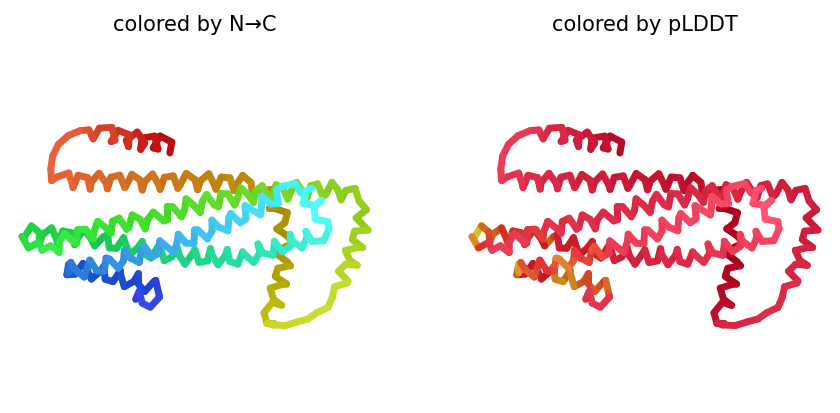

2026-01-01 16:48:25,455 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=42.7 pTM=0.254
2026-01-01 16:48:53,979 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=38.8 pTM=0.253 tol=17.1
2026-01-01 16:49:22,427 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=39.2 pTM=0.269 tol=9.97
2026-01-01 16:49:50,844 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=38.9 pTM=0.265 tol=4.1
2026-01-01 16:49:50,845 alphafold2_ptm_model_2_seed_000 took 113.8s (3 recycles)


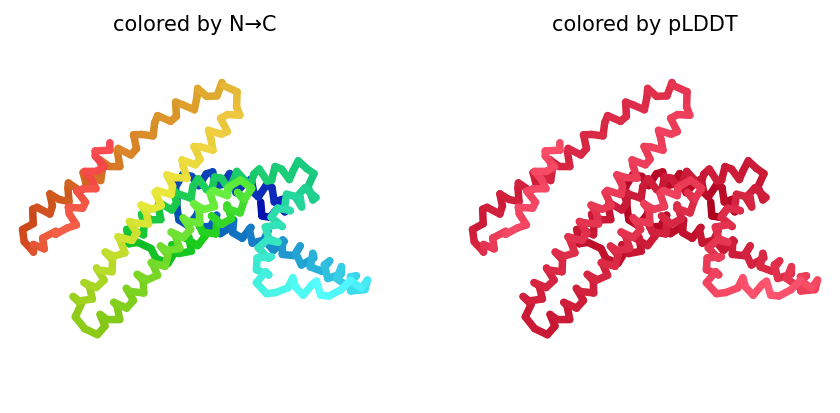

2026-01-01 16:50:19,651 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=35.6 pTM=0.229
2026-01-01 16:50:48,085 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=34.4 pTM=0.265 tol=9.52
2026-01-01 16:51:16,546 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=35.3 pTM=0.277 tol=2.88
2026-01-01 16:51:45,072 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=36.3 pTM=0.289 tol=1.53
2026-01-01 16:51:45,073 alphafold2_ptm_model_3_seed_000 took 113.9s (3 recycles)


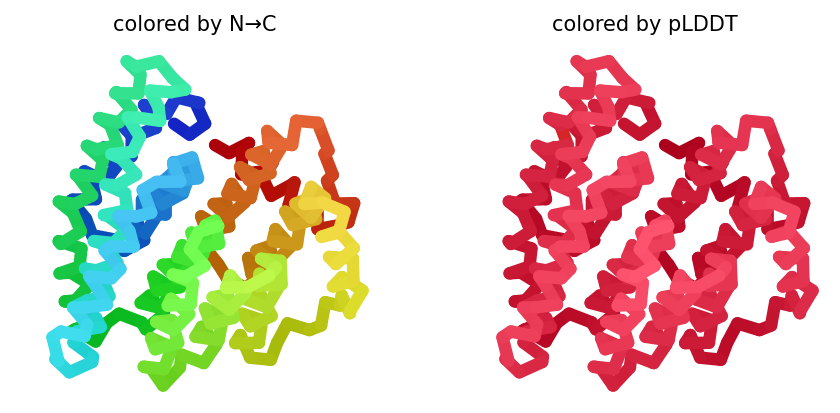

2026-01-01 16:52:13,877 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=44.8 pTM=0.258
2026-01-01 16:52:42,279 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=39.3 pTM=0.247 tol=9.63
2026-01-01 16:53:10,852 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=38.5 pTM=0.254 tol=4.06
2026-01-01 16:53:39,296 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=38.6 pTM=0.261 tol=1.7
2026-01-01 16:53:39,297 alphafold2_ptm_model_4_seed_000 took 113.8s (3 recycles)


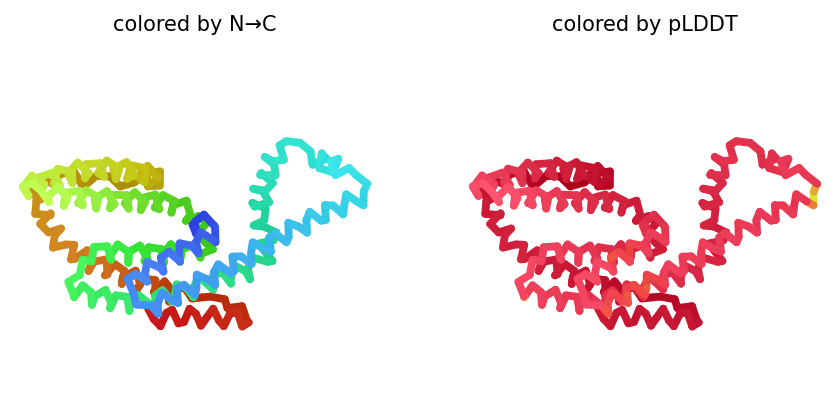

2026-01-01 16:54:08,028 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=41.2 pTM=0.243
2026-01-01 16:54:36,612 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=38.5 pTM=0.268 tol=11.2
2026-01-01 16:55:05,085 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=39.8 pTM=0.262 tol=8.51
2026-01-01 16:55:33,520 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=41 pTM=0.282 tol=2.68
2026-01-01 16:55:33,520 alphafold2_ptm_model_5_seed_000 took 113.9s (3 recycles)


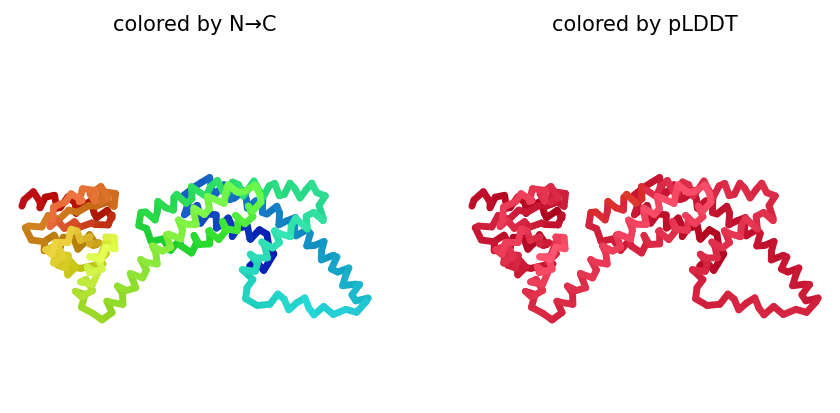

2026-01-01 16:55:33,828 reranking models by 'plddt' metric
2026-01-01 16:55:33,829 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=43.4 pTM=0.324
2026-01-01 16:55:33,829 rank_002_alphafold2_ptm_model_5_seed_000 pLDDT=41 pTM=0.282
2026-01-01 16:55:33,829 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=38.9 pTM=0.265
2026-01-01 16:55:33,829 rank_004_alphafold2_ptm_model_4_seed_000 pLDDT=38.6 pTM=0.261
2026-01-01 16:55:33,829 rank_005_alphafold2_ptm_model_3_seed_000 pLDDT=36.3 pTM=0.289
2026-01-01 16:55:35,215 Query 9/10: Sample_2_0_c63df (length 512)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


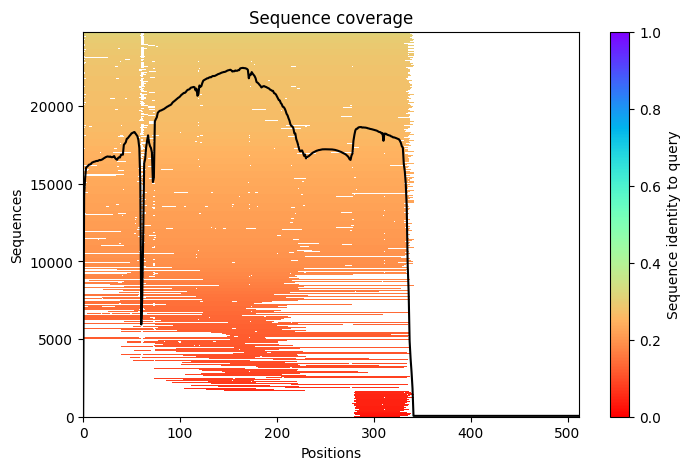

2026-01-01 16:57:41,259 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=62.6 pTM=0.486
2026-01-01 16:58:55,914 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=64.3 pTM=0.496 tol=18.1
2026-01-01 16:59:54,134 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=64.4 pTM=0.496 tol=5.74
2026-01-01 17:00:52,473 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=64.3 pTM=0.496 tol=4.83
2026-01-01 17:00:52,474 alphafold2_ptm_model_1_seed_000 took 280.7s (3 recycles)


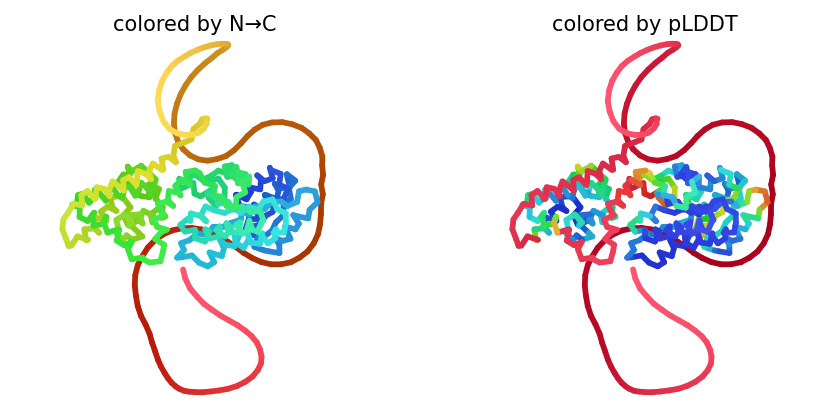

2026-01-01 17:01:51,242 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=60 pTM=0.467
2026-01-01 17:02:49,547 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=60.7 pTM=0.483 tol=7.3
2026-01-01 17:03:48,001 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=61.3 pTM=0.484 tol=3.33
2026-01-01 17:04:46,320 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=62.2 pTM=0.49 tol=1.85
2026-01-01 17:04:46,321 alphafold2_ptm_model_2_seed_000 took 233.4s (3 recycles)


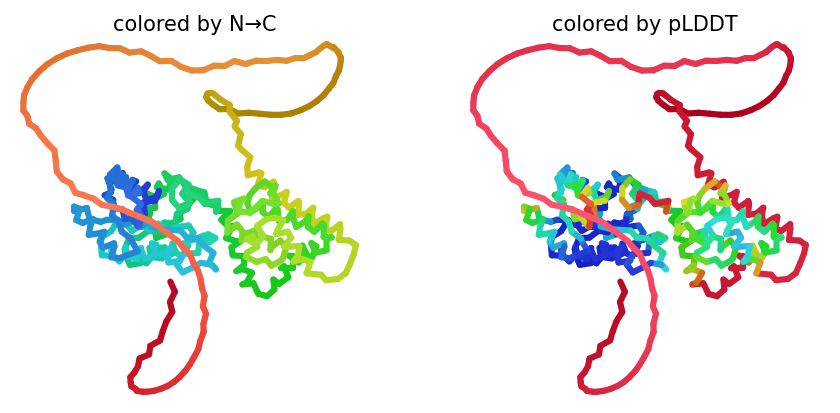

2026-01-01 17:05:45,114 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=62.8 pTM=0.476
2026-01-01 17:06:43,441 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=64.2 pTM=0.491 tol=7.61
2026-01-01 17:07:41,786 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=65 pTM=0.491 tol=5.42
2026-01-01 17:08:40,351 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=65.5 pTM=0.493 tol=3.29
2026-01-01 17:08:40,352 alphafold2_ptm_model_3_seed_000 took 233.6s (3 recycles)


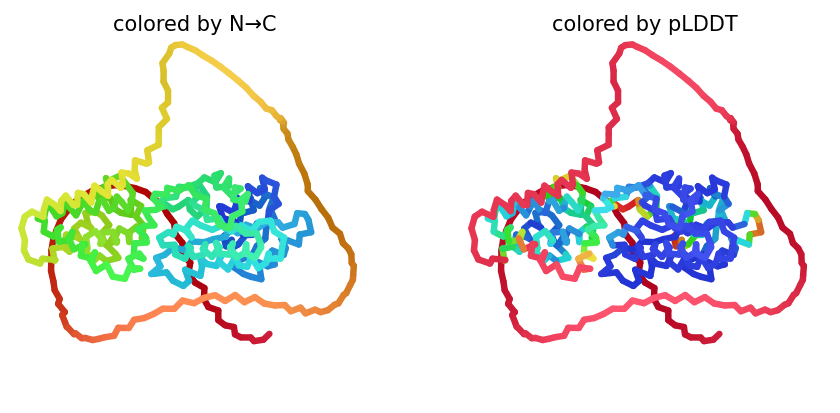

2026-01-01 17:09:39,426 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=61.8 pTM=0.497
2026-01-01 17:10:37,761 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=63.2 pTM=0.486 tol=8.55
2026-01-01 17:11:36,091 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=64.8 pTM=0.483 tol=6.06
2026-01-01 17:12:34,455 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=65.2 pTM=0.484 tol=4.19
2026-01-01 17:12:34,456 alphafold2_ptm_model_4_seed_000 took 233.4s (3 recycles)


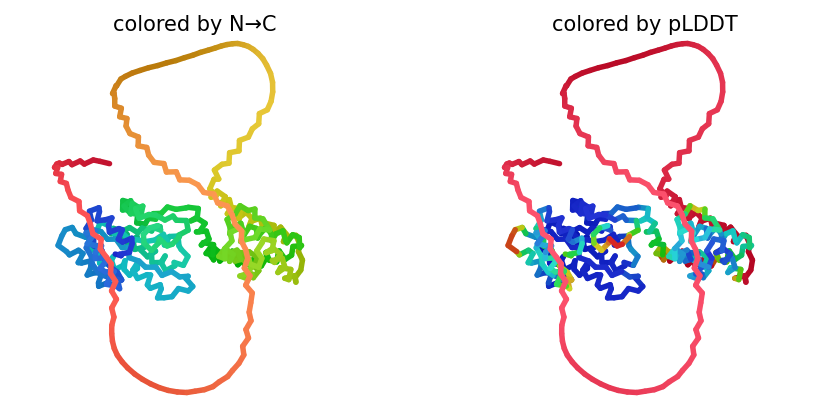

2026-01-01 17:13:33,477 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=62.1 pTM=0.49
2026-01-01 17:14:31,790 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=63.5 pTM=0.506 tol=7.7
2026-01-01 17:15:30,108 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=64.2 pTM=0.502 tol=6.11
2026-01-01 17:16:28,426 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=64.9 pTM=0.502 tol=4.32
2026-01-01 17:16:28,427 alphafold2_ptm_model_5_seed_000 took 233.5s (3 recycles)


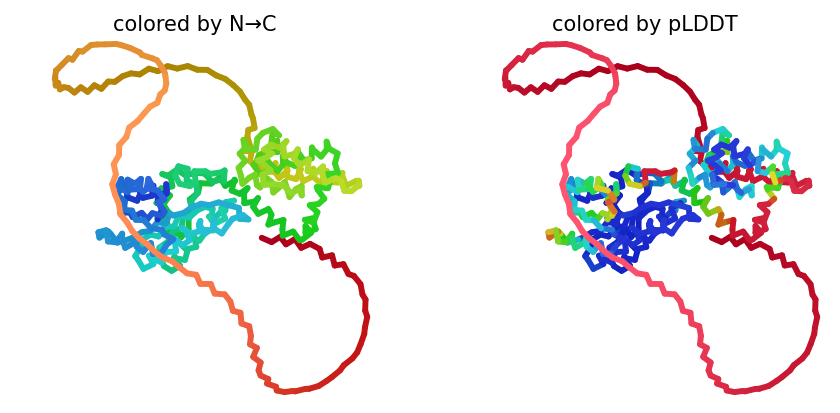

2026-01-01 17:16:28,946 reranking models by 'plddt' metric
2026-01-01 17:16:28,947 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=65.5 pTM=0.493
2026-01-01 17:16:28,947 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=65.2 pTM=0.484
2026-01-01 17:16:28,947 rank_003_alphafold2_ptm_model_5_seed_000 pLDDT=64.9 pTM=0.502
2026-01-01 17:16:28,947 rank_004_alphafold2_ptm_model_1_seed_000 pLDDT=64.3 pTM=0.496
2026-01-01 17:16:28,948 rank_005_alphafold2_ptm_model_2_seed_000 pLDDT=62.2 pTM=0.49
2026-01-01 17:16:30,649 Query 10/10: Sample_2_1_a3821 (length 512)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2026-01-01 17:16:30,976 Sleeping for 8s. Reason: PENDING


RUNNING:   5%|▌         | 8/150 [elapsed: 00:09 remaining: 02:51]

2026-01-01 17:16:40,338 Sleeping for 6s. Reason: RUNNING


RUNNING:   9%|▉         | 14/150 [elapsed: 00:16 remaining: 02:33]

2026-01-01 17:16:46,661 Sleeping for 5s. Reason: RUNNING


RUNNING:  13%|█▎        | 19/150 [elapsed: 00:21 remaining: 02:24]

2026-01-01 17:16:51,972 Sleeping for 8s. Reason: RUNNING


RUNNING:  18%|█▊        | 27/150 [elapsed: 00:29 remaining: 02:12]

2026-01-01 17:17:00,305 Sleeping for 5s. Reason: RUNNING


RUNNING:  21%|██▏       | 32/150 [elapsed: 00:34 remaining: 02:06]

2026-01-01 17:17:05,618 Sleeping for 6s. Reason: RUNNING


RUNNING:  25%|██▌       | 38/150 [elapsed: 00:41 remaining: 01:59]

2026-01-01 17:17:11,917 Sleeping for 9s. Reason: RUNNING


RUNNING:  31%|███▏      | 47/150 [elapsed: 00:50 remaining: 01:48]

2026-01-01 17:17:21,217 Sleeping for 9s. Reason: RUNNING


RUNNING:  37%|███▋      | 56/150 [elapsed: 00:59 remaining: 01:38]

2026-01-01 17:17:30,523 Sleeping for 6s. Reason: RUNNING


RUNNING:  41%|████▏     | 62/150 [elapsed: 01:06 remaining: 01:32]

2026-01-01 17:17:36,831 Sleeping for 8s. Reason: RUNNING


RUNNING:  47%|████▋     | 70/150 [elapsed: 01:14 remaining: 01:23]

2026-01-01 17:17:45,135 Sleeping for 6s. Reason: RUNNING


RUNNING:  51%|█████     | 76/150 [elapsed: 01:20 remaining: 01:17]

2026-01-01 17:17:51,434 Sleeping for 5s. Reason: RUNNING


RUNNING:  54%|█████▍    | 81/150 [elapsed: 01:26 remaining: 01:12]

2026-01-01 17:17:56,768 Sleeping for 8s. Reason: RUNNING


RUNNING:  59%|█████▉    | 89/150 [elapsed: 01:34 remaining: 01:03]

2026-01-01 17:18:05,086 Sleeping for 8s. Reason: RUNNING


RUNNING:  65%|██████▍   | 97/150 [elapsed: 01:42 remaining: 00:55]

2026-01-01 17:18:13,430 Sleeping for 10s. Reason: RUNNING


RUNNING:  71%|███████▏  | 107/150 [elapsed: 01:53 remaining: 00:44]

2026-01-01 17:18:23,739 Sleeping for 7s. Reason: RUNNING


RUNNING:  76%|███████▌  | 114/150 [elapsed: 02:00 remaining: 00:37]

2026-01-01 17:18:31,045 Sleeping for 7s. Reason: RUNNING


RUNNING:  81%|████████  | 121/150 [elapsed: 02:07 remaining: 00:30]

2026-01-01 17:18:38,350 Sleeping for 6s. Reason: RUNNING


RUNNING:  85%|████████▍ | 127/150 [elapsed: 02:14 remaining: 00:24]

2026-01-01 17:18:44,653 Sleeping for 10s. Reason: RUNNING


RUNNING:  91%|█████████▏| 137/150 [elapsed: 02:24 remaining: 00:13]

2026-01-01 17:18:54,960 Sleeping for 10s. Reason: RUNNING


RUNNING:  98%|█████████▊| 147/150 [elapsed: 02:34 remaining: 00:03]

2026-01-01 17:19:05,274 Sleeping for 10s. Reason: RUNNING


RUNNING: |          | 157/? [elapsed: 02:44 remaining: 00:00]

2026-01-01 17:19:15,587 Sleeping for 7s. Reason: RUNNING


RUNNING: |          | 164/? [elapsed: 02:52 remaining: 00:00]

2026-01-01 17:19:22,889 Sleeping for 10s. Reason: RUNNING


RUNNING: |          | 174/? [elapsed: 03:02 remaining: 00:00]

2026-01-01 17:19:33,190 Sleeping for 6s. Reason: RUNNING


RUNNING: |          | 180/? [elapsed: 03:09 remaining: 00:00]

2026-01-01 17:19:39,808 Sleeping for 8s. Reason: RUNNING


RUNNING: |          | 188/? [elapsed: 03:17 remaining: 00:00]

2026-01-01 17:19:48,148 Sleeping for 8s. Reason: RUNNING


RUNNING: |          | 196/? [elapsed: 03:25 remaining: 00:00]

2026-01-01 17:19:56,451 Sleeping for 8s. Reason: RUNNING


RUNNING: |          | 204/? [elapsed: 03:34 remaining: 00:00]

2026-01-01 17:20:04,748 Sleeping for 9s. Reason: RUNNING


RUNNING: |          | 213/? [elapsed: 03:43 remaining: 00:00]

2026-01-01 17:20:14,074 Sleeping for 5s. Reason: RUNNING


RUNNING: |          | 218/? [elapsed: 03:48 remaining: 00:00]

2026-01-01 17:20:19,405 Sleeping for 8s. Reason: RUNNING


RUNNING: |          | 226/? [elapsed: 03:57 remaining: 00:00]

2026-01-01 17:20:27,720 Sleeping for 8s. Reason: RUNNING


RUNNING: |          | 234/? [elapsed: 04:05 remaining: 00:00]

2026-01-01 17:20:36,041 Sleeping for 10s. Reason: RUNNING


RUNNING: |          | 244/? [elapsed: 04:15 remaining: 00:00]

2026-01-01 17:20:46,352 Sleeping for 9s. Reason: RUNNING


RUNNING: |          | 253/? [elapsed: 04:25 remaining: 00:00]

2026-01-01 17:20:55,667 Sleeping for 5s. Reason: RUNNING


RUNNING: |          | 258/? [elapsed: 04:30 remaining: 00:00]

2026-01-01 17:21:00,984 Sleeping for 7s. Reason: RUNNING


RUNNING: |          | 265/? [elapsed: 04:37 remaining: 00:00]

2026-01-01 17:21:08,312 Sleeping for 6s. Reason: RUNNING


RUNNING: |          | 271/? [elapsed: 04:44 remaining: 00:00]

2026-01-01 17:21:14,650 Sleeping for 10s. Reason: RUNNING


RUNNING: |          | 281/? [elapsed: 04:54 remaining: 00:00]

2026-01-01 17:21:24,949 Sleeping for 10s. Reason: RUNNING


RUNNING: |          | 291/? [elapsed: 05:04 remaining: 00:00]

2026-01-01 17:21:35,269 Sleeping for 6s. Reason: RUNNING


RUNNING: |          | 297/? [elapsed: 05:10 remaining: 00:00]

2026-01-01 17:21:41,575 Sleeping for 10s. Reason: RUNNING


RUNNING: |          | 307/? [elapsed: 05:21 remaining: 00:00]

2026-01-01 17:21:51,918 Sleeping for 9s. Reason: RUNNING


RUNNING: |          | 316/? [elapsed: 05:30 remaining: 00:00]

2026-01-01 17:22:01,222 Sleeping for 5s. Reason: RUNNING


RUNNING: |          | 321/? [elapsed: 05:35 remaining: 00:00]

2026-01-01 17:22:06,558 Sleeping for 6s. Reason: RUNNING


COMPLETE: |          | 321/? [elapsed: 05:43 remaining: 00:00]


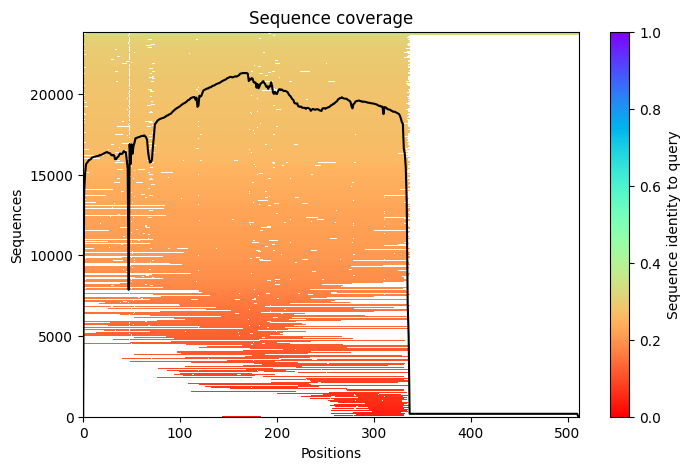

2026-01-01 17:23:45,819 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=60.3 pTM=0.45
2026-01-01 17:24:43,989 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=60.5 pTM=0.467 tol=7.34
2026-01-01 17:25:42,328 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=61.2 pTM=0.474 tol=6.43
2026-01-01 17:26:40,813 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=60 pTM=0.474 tol=6.07
2026-01-01 17:26:40,815 alphafold2_ptm_model_1_seed_000 took 233.6s (3 recycles)


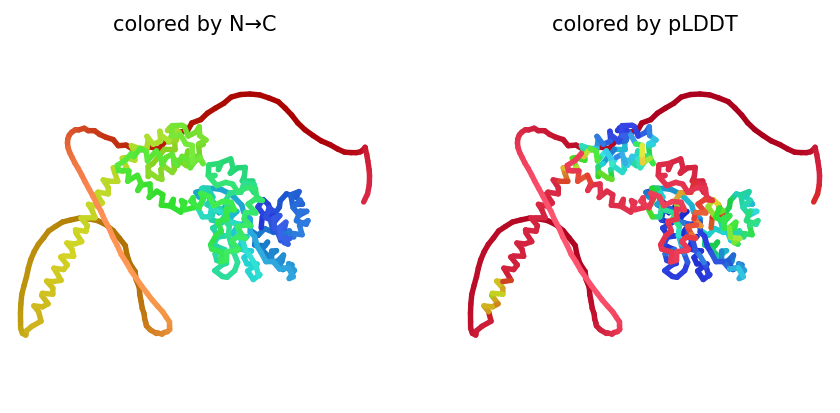

2026-01-01 17:27:39,851 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=57.4 pTM=0.441
2026-01-01 17:28:38,115 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=55.2 pTM=0.434 tol=7.46
2026-01-01 17:29:36,350 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=54.8 pTM=0.421 tol=5.48
2026-01-01 17:30:34,895 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=54.9 pTM=0.423 tol=2.94
2026-01-01 17:30:34,897 alphafold2_ptm_model_2_seed_000 took 233.4s (3 recycles)


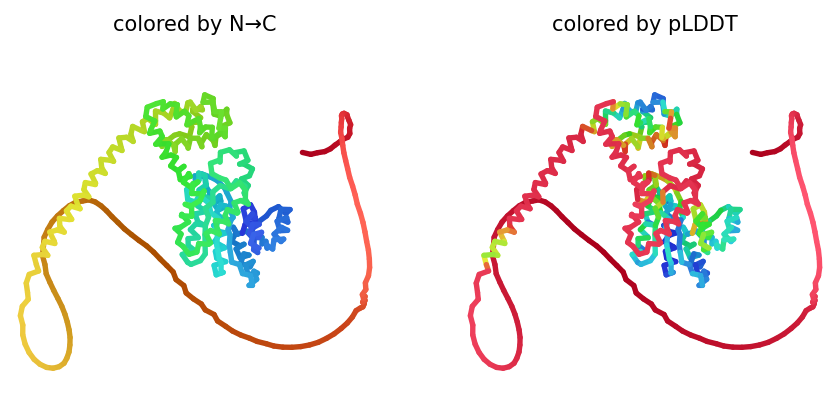

2026-01-01 17:31:33,776 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=60.9 pTM=0.442
2026-01-01 17:32:32,076 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=58.3 pTM=0.443 tol=11.1
2026-01-01 17:33:30,341 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=58.2 pTM=0.45 tol=4.21
2026-01-01 17:34:28,614 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=57.9 pTM=0.453 tol=2.38
2026-01-01 17:34:28,615 alphafold2_ptm_model_3_seed_000 took 233.2s (3 recycles)


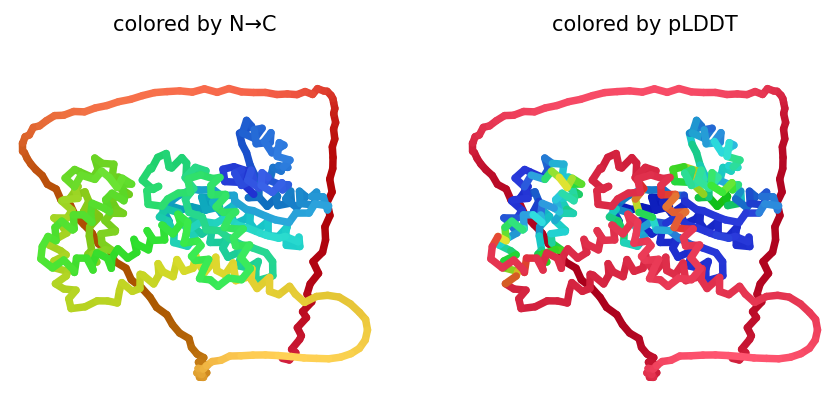

2026-01-01 17:35:27,656 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=60.5 pTM=0.45
2026-01-01 17:36:26,027 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=58.6 pTM=0.447 tol=9.73
2026-01-01 17:37:24,346 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=59.2 pTM=0.463 tol=7.04
2026-01-01 17:38:22,700 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=59.2 pTM=0.466 tol=4.5
2026-01-01 17:38:22,701 alphafold2_ptm_model_4_seed_000 took 233.6s (3 recycles)


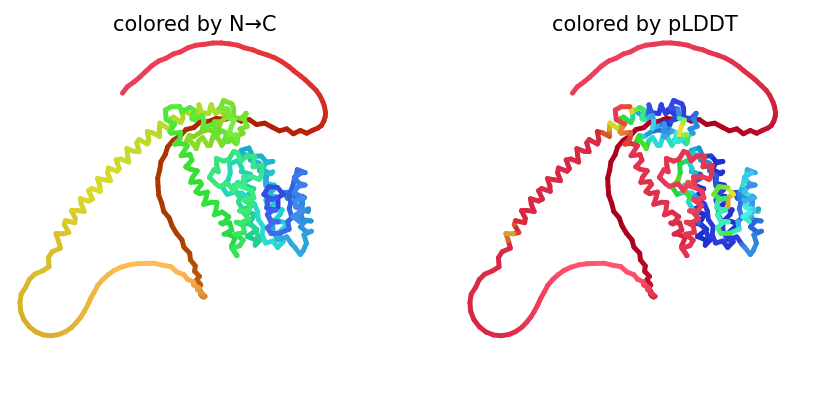

2026-01-01 17:39:21,759 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=60.1 pTM=0.452
2026-01-01 17:40:20,077 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=59.2 pTM=0.481 tol=10.3
2026-01-01 17:41:18,367 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=59.3 pTM=0.464 tol=4.95
2026-01-01 17:42:16,672 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=58.8 pTM=0.471 tol=6.25
2026-01-01 17:42:16,673 alphafold2_ptm_model_5_seed_000 took 233.5s (3 recycles)


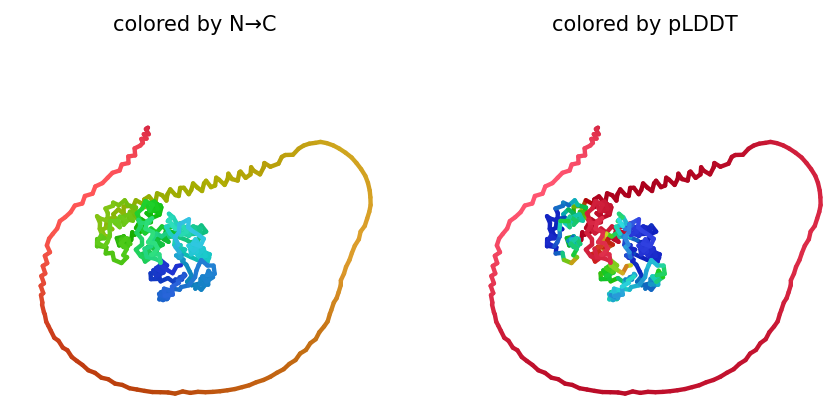

2026-01-01 17:42:17,168 reranking models by 'plddt' metric
2026-01-01 17:42:17,169 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=60 pTM=0.474
2026-01-01 17:42:17,169 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=59.2 pTM=0.466
2026-01-01 17:42:17,169 rank_003_alphafold2_ptm_model_5_seed_000 pLDDT=58.8 pTM=0.471
2026-01-01 17:42:17,170 rank_004_alphafold2_ptm_model_3_seed_000 pLDDT=57.9 pTM=0.453
2026-01-01 17:42:17,170 rank_005_alphafold2_ptm_model_2_seed_000 pLDDT=54.9 pTM=0.423
2026-01-01 17:42:18,913 Done


0

In [15]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

Using structure: test_983d6/Sample_0_1_c5282_unrelaxed_rank_001_alphafold2_ptm_model_4_seed_000.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

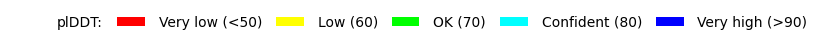

In [18]:
import glob
import py3Dmol
from colabfold.colabfold import pymol_color_list, alphabet_list, plot_plddt_legend

rank_num = 1
color = "lDDT"
show_sidechains = False
show_mainchains = False

# if you have multiple sequences, pick which one’s results to use
query_idx = 0  # 0..N-1

tag = results["rank"][query_idx][rank_num - 1]

def _pick_structure_file(jobname: str, tag: str):
    # match your real filenames: <prefix>_unrelaxed_<tag>.pdb
    patterns = [
        f"{jobname}/*_unrelaxed_{tag}.pdb",
        f"{jobname}/*_relaxed_{tag}.pdb",
        f"{jobname}/*_unrelaxed_{tag}.cif",
        f"{jobname}/*_relaxed_{tag}.cif",
        f"{jobname}/*{tag}*.pdb",
        f"{jobname}/*{tag}*.cif",
    ]
    for p in patterns:
        hits = glob.glob(p)
        if hits:
            return hits[0]
    raise FileNotFoundError(
        f"Could not find a structure file for tag={tag}\nTried:\n" + "\n".join(patterns) +
        "\n\nFound PDBs:\n" + "\n".join(glob.glob(f"{jobname}/*.pdb")[:50])
    )

def show_structure(jobname, tag, show_sidechains=False, show_mainchains=False, color="lDDT"):
    path = _pick_structure_file(jobname, tag)
    print("Using structure:", path)

    view = py3Dmol.view(js="https://3dmol.org/build/3Dmol.js")
    fmt = "pdb" if path.endswith(".pdb") else "cif"
    view.addModel(open(path, "r").read(), fmt)

    if color == "lDDT":
        view.setStyle({"cartoon": {"colorscheme": {"prop": "b", "gradient": "roygb", "min": 50, "max": 90}}})
    elif color == "rainbow":
        view.setStyle({"cartoon": {"color": "spectrum"}})
    elif color == "chain":
        # simple chain coloring; works for most single-chain cases
        for chain_id, col in zip(alphabet_list, pymol_color_list):
            view.setStyle({"chain": chain_id}, {"cartoon": {"color": col}})

    if show_sidechains:
        BB = ["C", "O", "N"]
        view.addStyle({"and": [{"resn": ["GLY", "PRO"], "invert": True}, {"atom": BB, "invert": True}]},
                      {"stick": {"colorscheme": "WhiteCarbon", "radius": 0.3}})
        view.addStyle({"and": [{"resn": "GLY"}, {"atom": "CA"}]},
                      {"sphere": {"colorscheme": "WhiteCarbon", "radius": 0.3}})
        view.addStyle({"and": [{"resn": "PRO"}, {"atom": ["C", "O"], "invert": True}]},
                      {"stick": {"colorscheme": "WhiteCarbon", "radius": 0.3}})

    if show_mainchains:
        BB = ["C", "O", "N", "CA"]
        view.addStyle({"atom": BB}, {"stick": {"colorscheme": "WhiteCarbon", "radius": 0.3}})

    view.zoomTo()
    return view

show_structure(jobname, tag, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
    plot_plddt_legend().show()


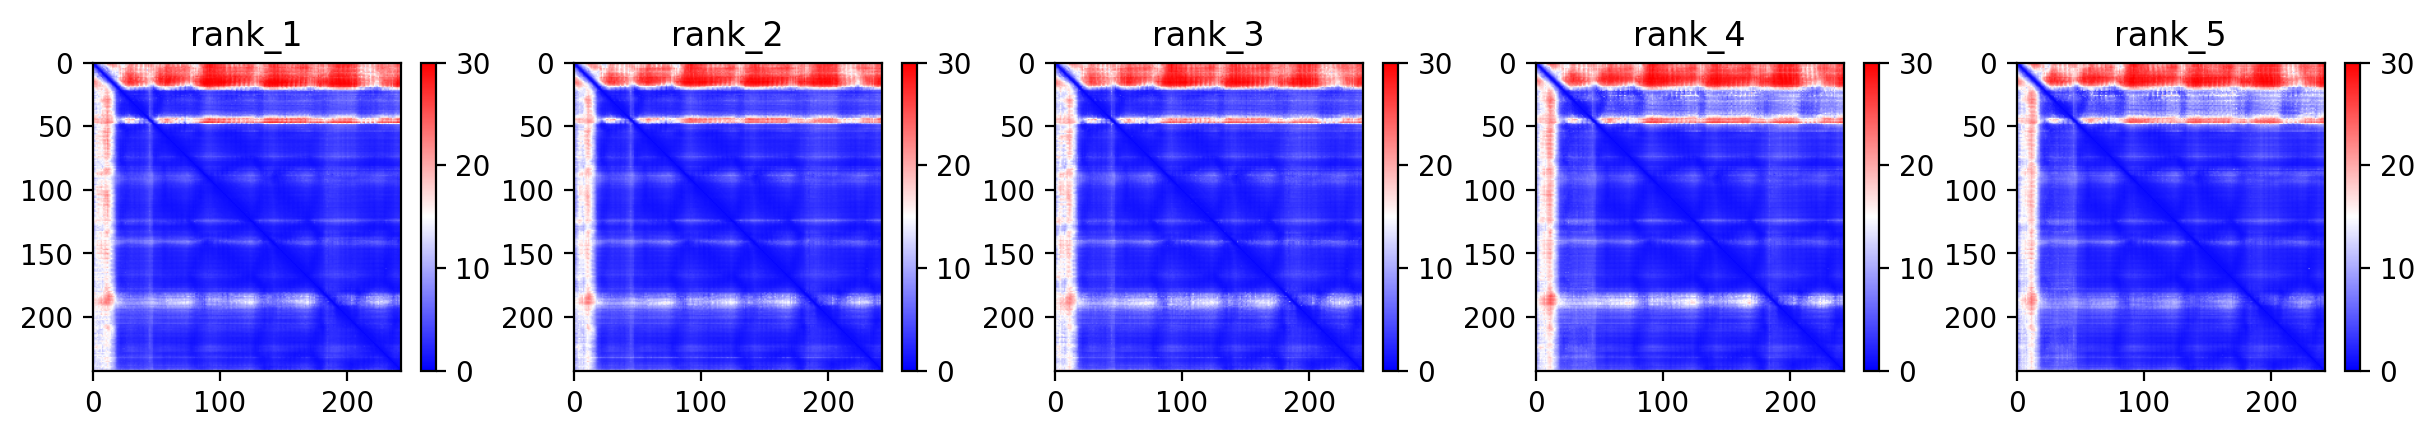
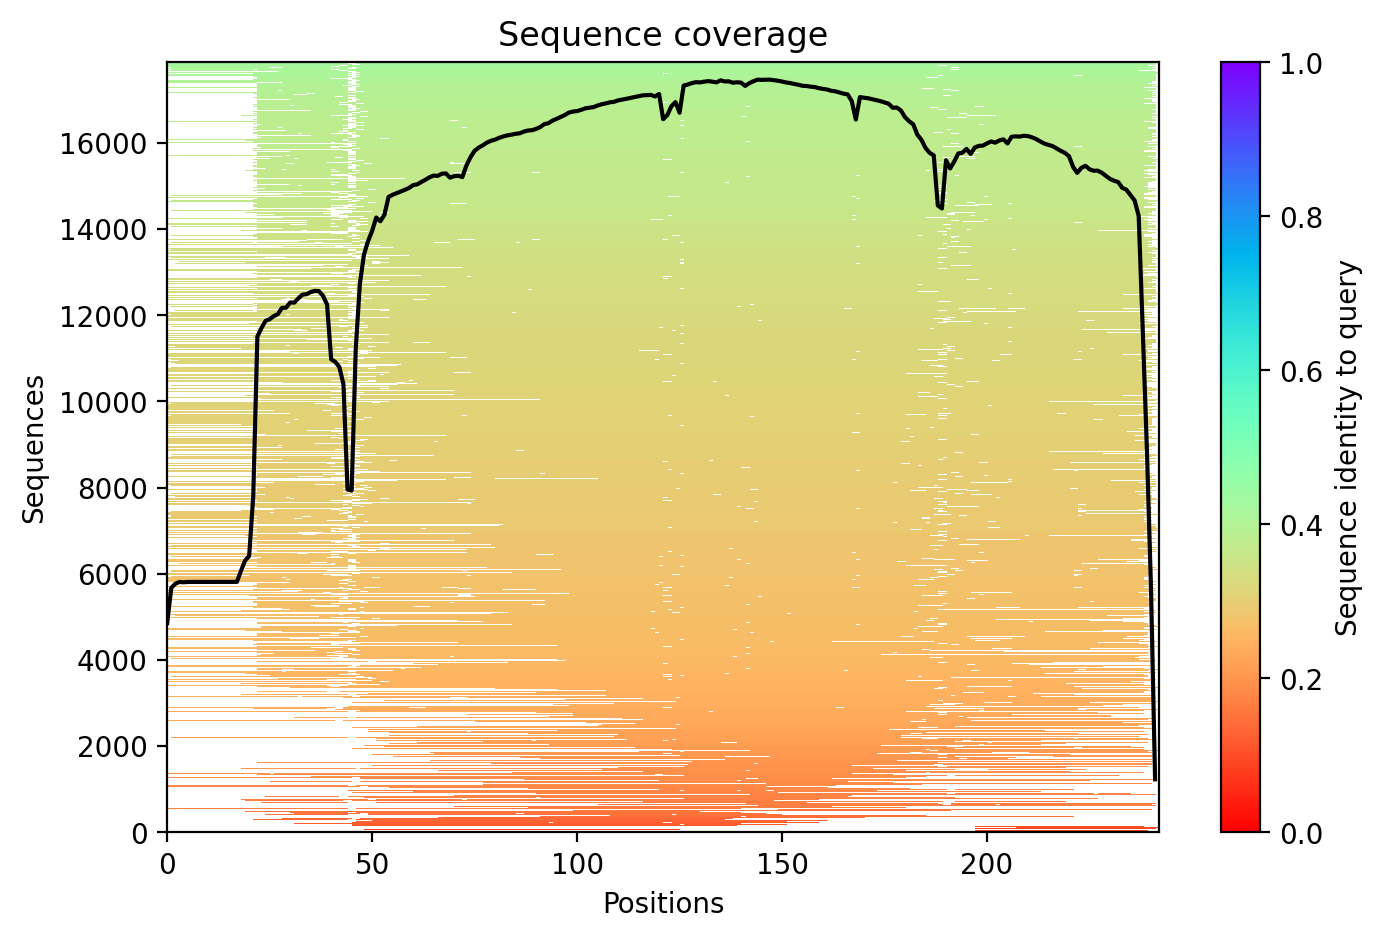
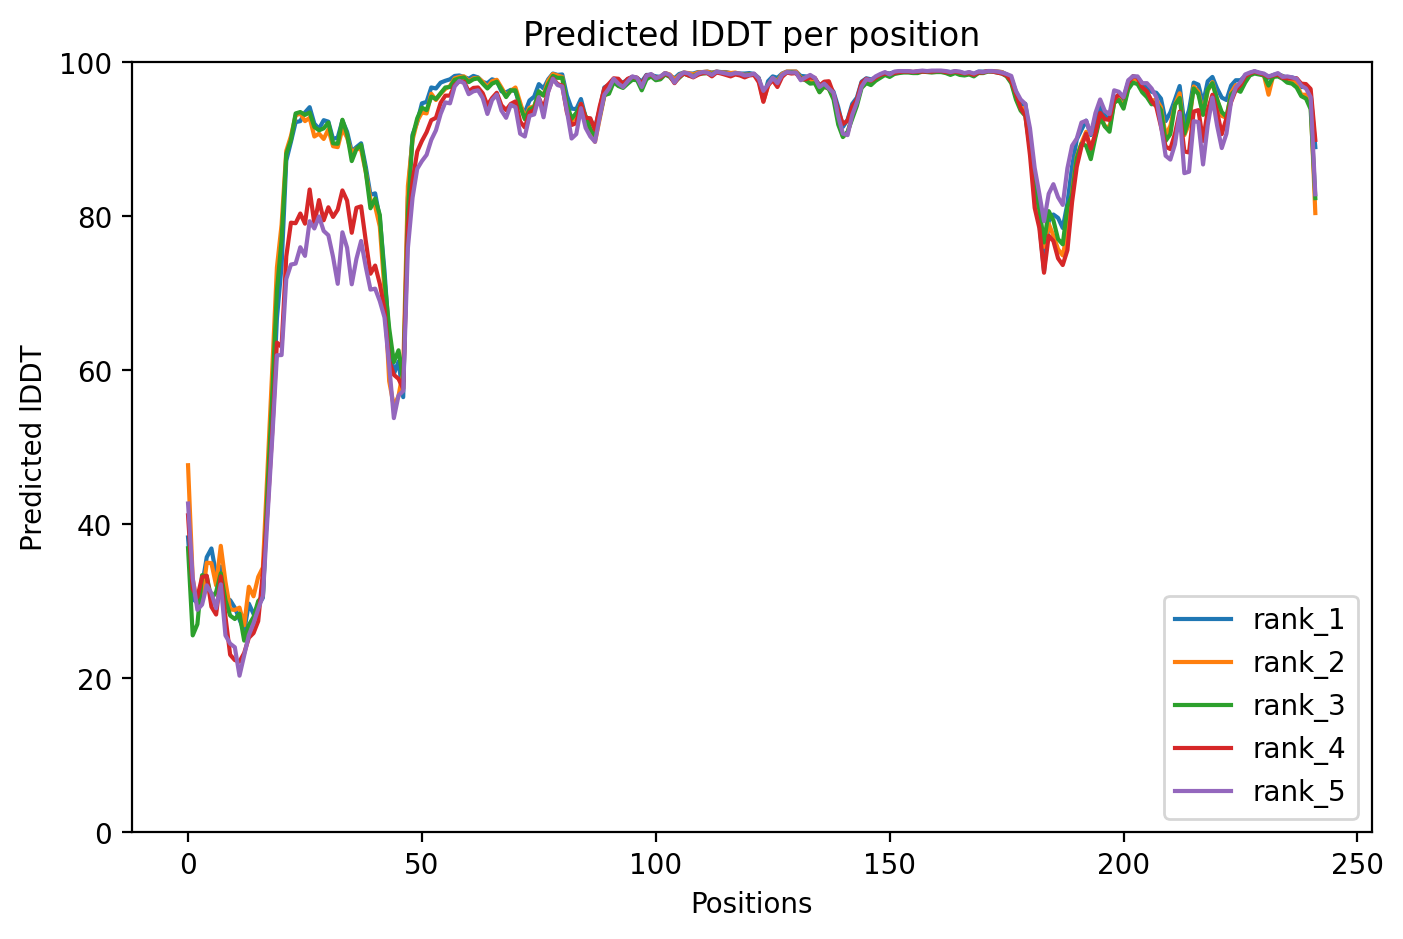

In [21]:
from IPython.display import display, HTML
import base64
from html import escape
import os
import glob

# choose which sequence in your multi-sequence run to show plots for
query_idx = 0  # 0..len(queries)-1
query_id = queries[query_idx][0]  # e.g. "Sample_0_0_89f2b"
jobname_prefix = ".custom" if msa_mode == "custom" else ""

def image_to_data_url(filename):
    ext = filename.split(".")[-1].lower()
    prefix = f"data:image/{ext};base64,"
    with open(filename, "rb") as f:
        img = f.read()
    return prefix + base64.b64encode(img).decode("utf-8")

def pick_first_existing(patterns):
    for p in patterns:
        hits = glob.glob(p)
        if hits:
            return hits[0]
    return None

# Try per-sequence filenames first, then fall back to jobname-based filenames
pae_path = pick_first_existing([
    os.path.join(jobname, f"{query_id}{jobname_prefix}_pae.png"),
    os.path.join(jobname, f"{query_id}_pae.png"),
    os.path.join(jobname, f"{jobname}{jobname_prefix}_pae.png"),
])

cov_path = pick_first_existing([
    os.path.join(jobname, f"{query_id}{jobname_prefix}_coverage.png"),
    os.path.join(jobname, f"{query_id}_coverage.png"),
    os.path.join(jobname, f"{jobname}{jobname_prefix}_coverage.png"),
])

plddt_path = pick_first_existing([
    os.path.join(jobname, f"{query_id}{jobname_prefix}_plddt.png"),
    os.path.join(jobname, f"{query_id}_plddt.png"),
    os.path.join(jobname, f"{jobname}{jobname_prefix}_plddt.png"),
])

pae = image_to_data_url(pae_path) if pae_path else ""
cov = image_to_data_url(cov_path) if cov_path else ""
plddt = image_to_data_url(plddt_path) if plddt_path else ""

missing = []
if not cov_path: missing.append("coverage")
if not plddt_path: missing.append("plddt")

display(HTML(f"""
<style>
  img {{ float:left; }}
  .full {{ max-width:100%; }}
  .half {{ max-width:50%; }}
  @media (max-width:640px) {{ .half {{ max-width:100%; }} }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(query_id)} (folder: {escape(jobname)})</h1>
  {f"<p><b>Missing:</b> {', '.join(missing)}</p>" if missing else ""}
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  { '<!--' if cov == '' else '' }<img src="{cov}" class="half" />{ '-->' if cov == '' else '' }
  { '<!--' if plddt == '' else '' }<img src="{plddt}" class="half" />{ '-->' if plddt == '' else '' }
</div>
"""))

In [17]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to provide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
